## Exploratory Data Analysis

In this section we are conding some EDA techniques. current tasks involve time series, so focucsing
techniques that can work well with time series.

Currently we have multiple sensors data captures at various time points before measuing the even(
we have multiple event to predict )



### Imports

In [1]:
from typing import Optional, Any
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import seaborn as sns
from tslearn.clustering import silhouette_score
from tslearn.utils import to_time_series_dataset

import matplotlib.pyplot as plt

### Inputs

In [2]:
DATA_PATH = './data/'
SEPERATOR = '\t'
PROFILE_COLUMNS= ['cooler','valve', 'pump_lekage', 'accumulator', 'stable_flag']

FILES_NAMES = {
    'temperature': ['TS1', 'TS2', 'TS3', 'TS4'],
    'pressure': ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6'],
    'motor_power': ['EPS1'],
    'volume_flow': ['FS1', 'FS2'],
    'vibration': ['VS1'],
    'cooling_efficiency': ['CE'],
    'cooling_power': ['CP'],
    'efficiency_factor': ['SE']
}

### Helper functions

In [3]:
def ts_cluster_with_best_k(ts_: np.ndarray, title: Optional[str] = None) -> np.array:
    """cluster time series

    Args:
        ts_ (np.ndarray): 3d time series convert using to_time_series_dataset
        title (str): title for plot, mostly variable name

    Returns:
        np.array: clusters 
    """
    silhouette = {}
    best_k = None
    init_silhouette = 0
    for i in range(2, 20, 1):
        km_clusters = TimeSeriesKMeans(
            n_clusters=i, 
            metric="euclidean", 
            n_init=5,
            max_iter=50, 
            random_state=5, 
            n_jobs=-1
        )
        clusters_ids = km_clusters.fit_predict(ts_)
        silhouette[i] = silhouette_score(
            ts_, clusters_ids, n_jobs=-1, sample_size=250, metric='euclidean'
        )
        if silhouette[i]> init_silhouette:
            init_silhouette = silhouette[i]
            best_k = i

    plt.figure(figsize=(20,2))
    plt.plot([str(i) for i in silhouette.keys()], silhouette.values())
    plt.title(f"{title} (Best K = {best_k})")
    plt.xlabel("Clusters")
    plt.ylabel("silhouette Score")

    km_clusters.set_params(n_clusters=best_k)
    km_clusters.fit(ts_)
    return km_clusters

def plot_target_counts_in_cluster(df: pd.DataFrame, cluster_col: str) -> None:
    """Seperation plots for all targets

    Args:
        df (pd.DataFrame): target dataset with clusters
        cluster_col (str): cluster column
    """
    fig, ax = plt.subplots(2,2, figsize=(20,4.5))
    for target_col, plot_axis in zip(PROFILE_COLUMNS, ax.flatten()):
        agg_ = df[[cluster_col,target_col]].value_counts().unstack().fillna(0)
        agg_.plot(kind='barh', stacked=True, ax=plot_axis, title = f"{target_col}", xlabel='counts')
    fig.tight_layout()

def plot_cluster_shapes(ts_arr: np.ndarray, km_cluster_fit: Any) -> None:
    """Plot time series into each cluster

    Args:
        ts_arr (np.ndarray): 3d time series convert using to_time_series_dataset
        km_cluster_data (Any): cluster fit
    """
    k = np.unique(km_cluster_fit.labels_).shape[0]
    fig, ax = plt.subplots(1, k, figsize=(20, 4.5))
    ax = ax.flatten()
    for cluster, ax_ in zip(range(k), ax) :
        for xx in ts_arr[km_cluster_fit.labels_ == cluster]:
            ax_.plot(xx.ravel(), "k-", alpha=.2)
        ax_.plot(km_cluster_fit.cluster_centers_[cluster].ravel(), "r-")
        ax_.set_title(f"Cluster: {cluster}")
    fig.tight_layout()

### Load data

In [4]:
target = pd.read_csv(F'{DATA_PATH}/profile.txt',sep=SEPERATOR, names=PROFILE_COLUMNS)
print(f"Target data array shape : {target.shape}")

# Load data and converting data into TS arrays
ts_data_array = {}
for sensor_type, data_file_names_list in FILES_NAMES.items():
    data_array_ = {}
    for file_name in data_file_names_list:
        # read txt file
        ts_data = pd.read_csv(f'./data/{file_name}.txt', sep='\t', header=None)
        # transform column data to TS array for TSKmeansClustring.
        ts_array = to_time_series_dataset(ts_data)
        data_array_[f"{sensor_type}_{file_name}"] = ts_array
        print(f"{sensor_type} {file_name} data array shape : {ts_array.shape}")

    if len(data_file_names_list)>1:
        all_array = np.concatenate(list(data_array_.values()), axis=2)
        data_array_[f"{sensor_type}_all"] = all_array
        print(f"{sensor_type} all files array shape : {all_array.shape}")
    ts_data_array[sensor_type] = data_array_

Target data array shape : (2205, 5)
temperature TS1 data array shape : (2205, 60, 1)
temperature TS2 data array shape : (2205, 60, 1)
temperature TS3 data array shape : (2205, 60, 1)
temperature TS4 data array shape : (2205, 60, 1)
temperature all files array shape : (2205, 60, 4)
pressure PS1 data array shape : (2205, 6000, 1)
pressure PS2 data array shape : (2205, 6000, 1)
pressure PS3 data array shape : (2205, 6000, 1)
pressure PS4 data array shape : (2205, 6000, 1)
pressure PS5 data array shape : (2205, 6000, 1)
pressure PS6 data array shape : (2205, 6000, 1)
pressure all files array shape : (2205, 6000, 6)
motor_power EPS1 data array shape : (2205, 6000, 1)
volume_flow FS1 data array shape : (2205, 600, 1)
volume_flow FS2 data array shape : (2205, 600, 1)
volume_flow all files array shape : (2205, 600, 2)
vibration VS1 data array shape : (2205, 60, 1)
cooling_efficiency CE data array shape : (2205, 60, 1)
cooling_power CP data array shape : (2205, 60, 1)
efficiency_factor SE data 

## EDS using Time Series Clusting
### Temperature

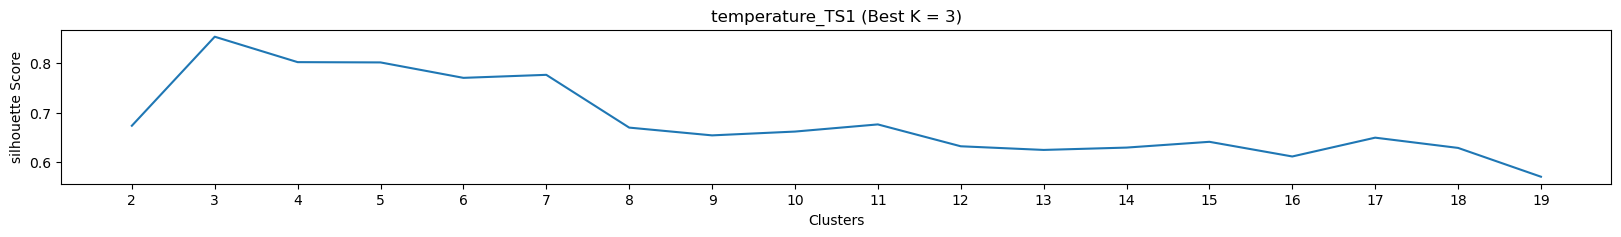

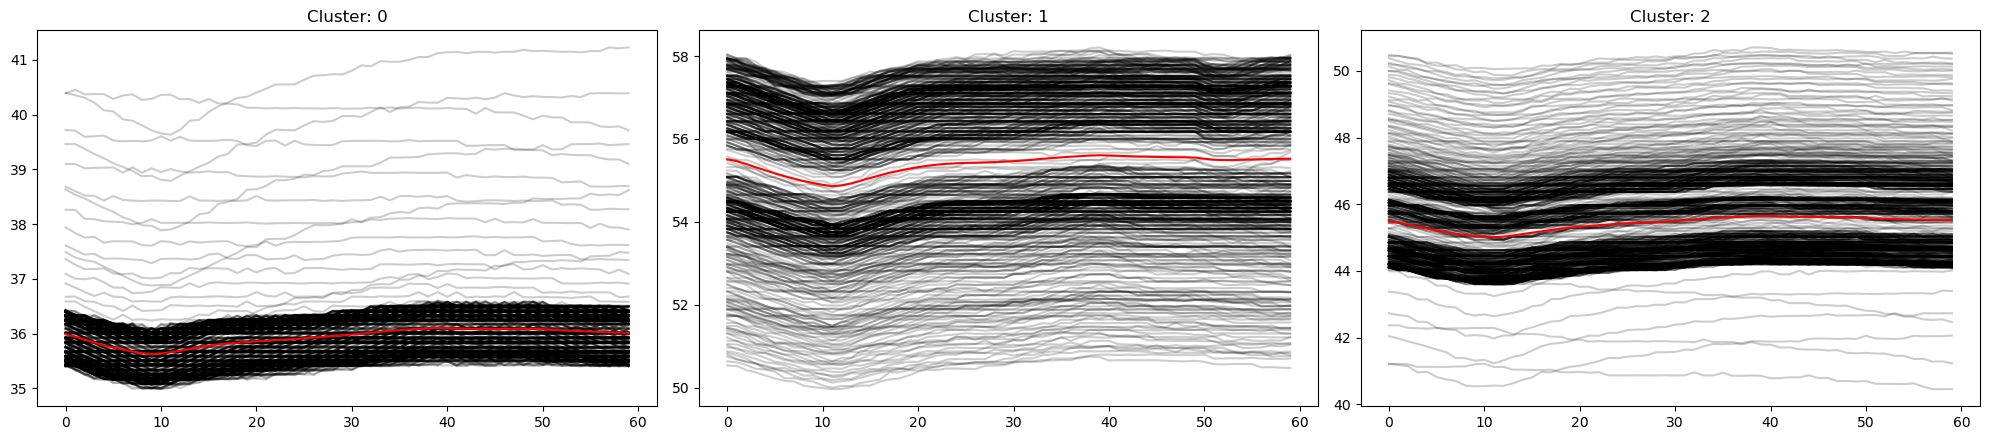

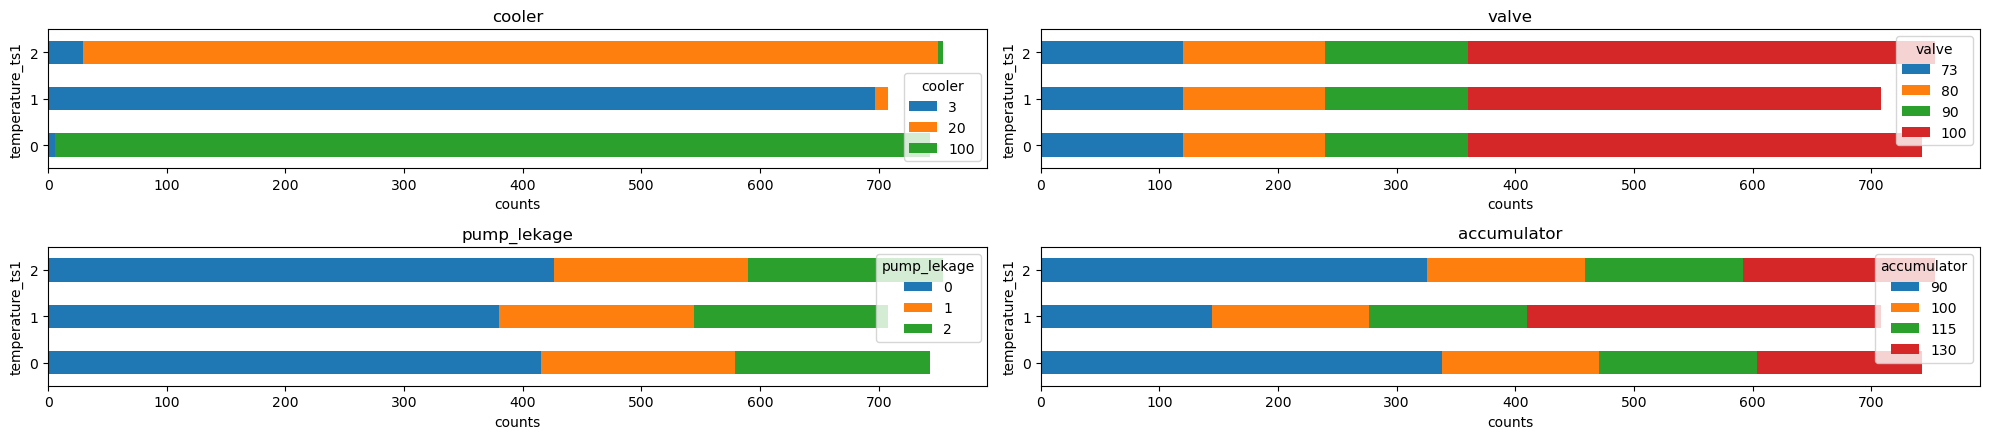

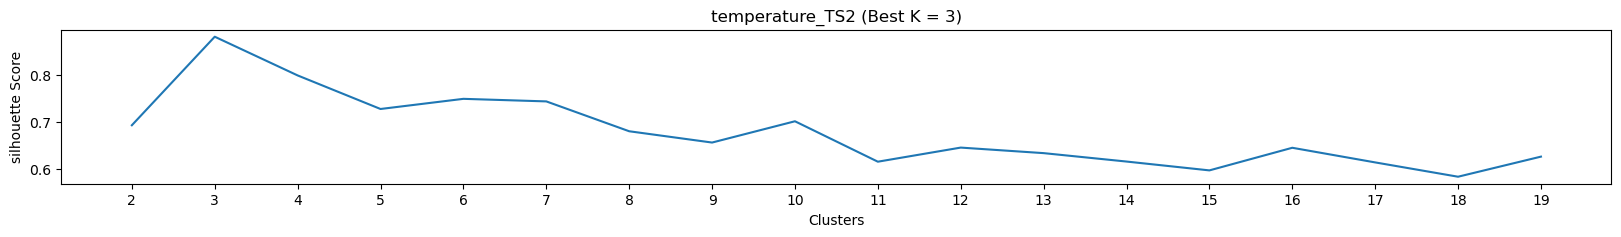

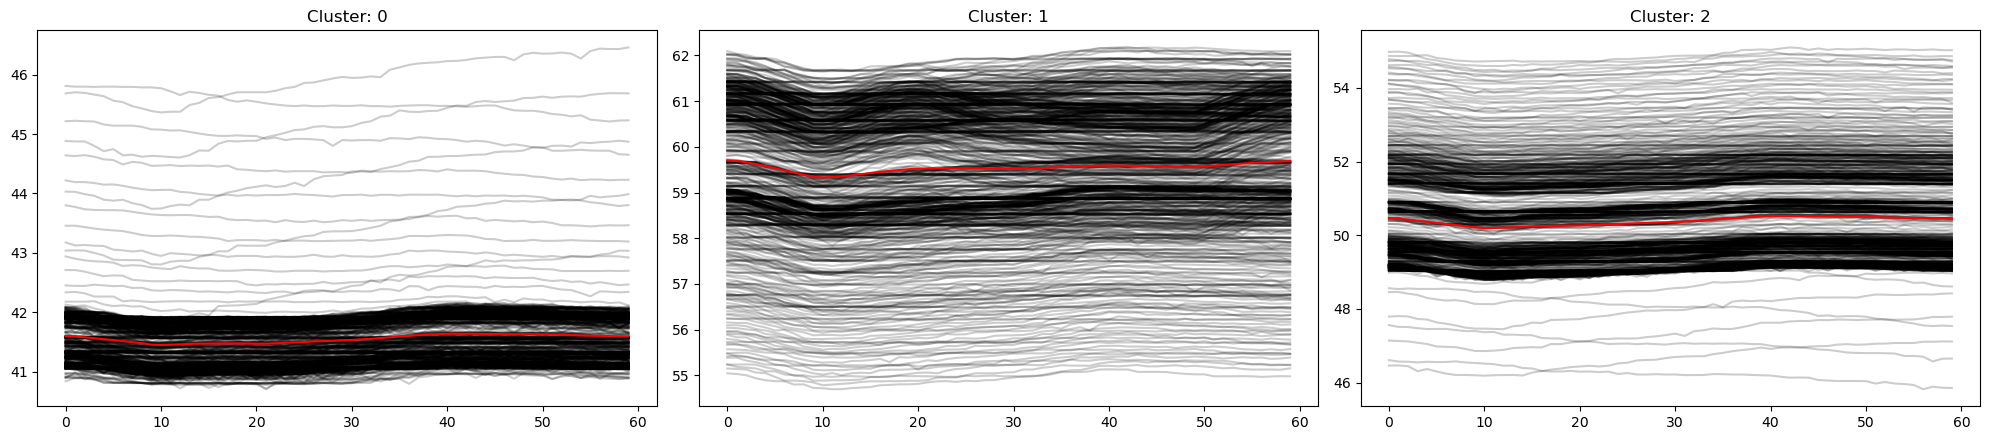

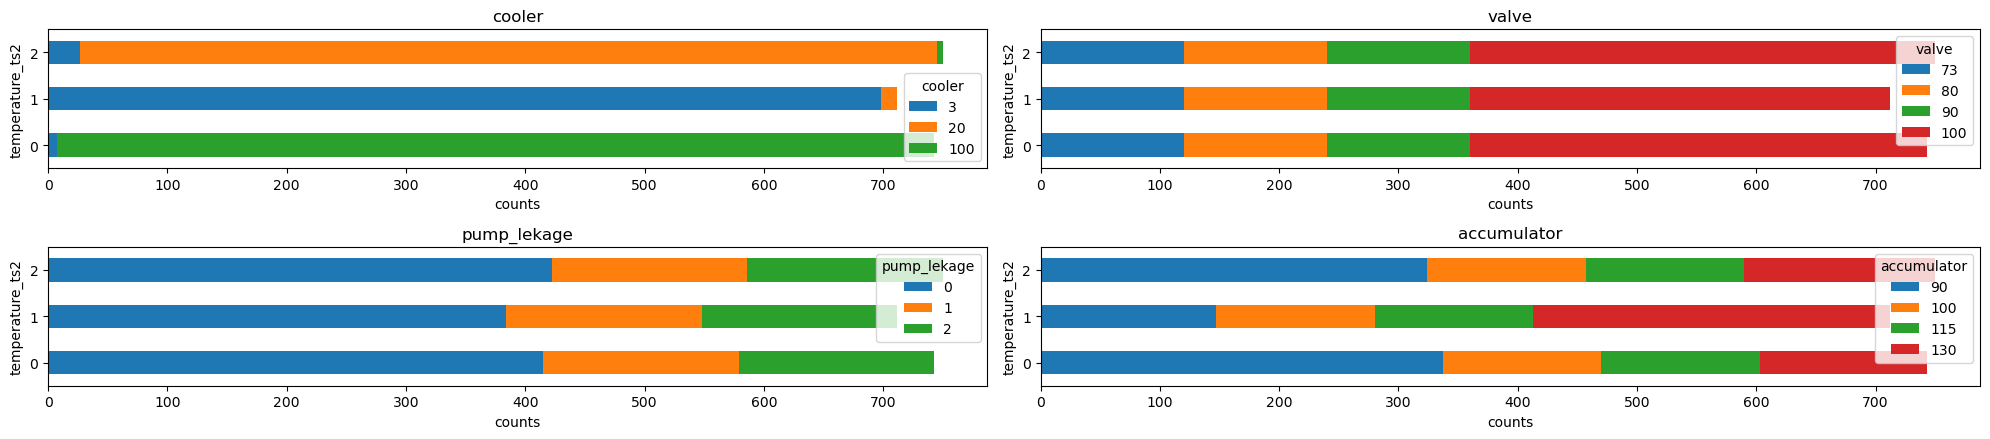

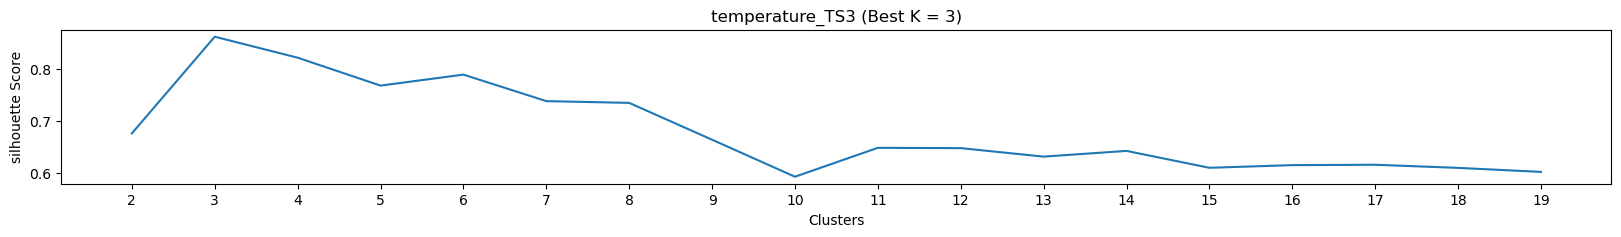

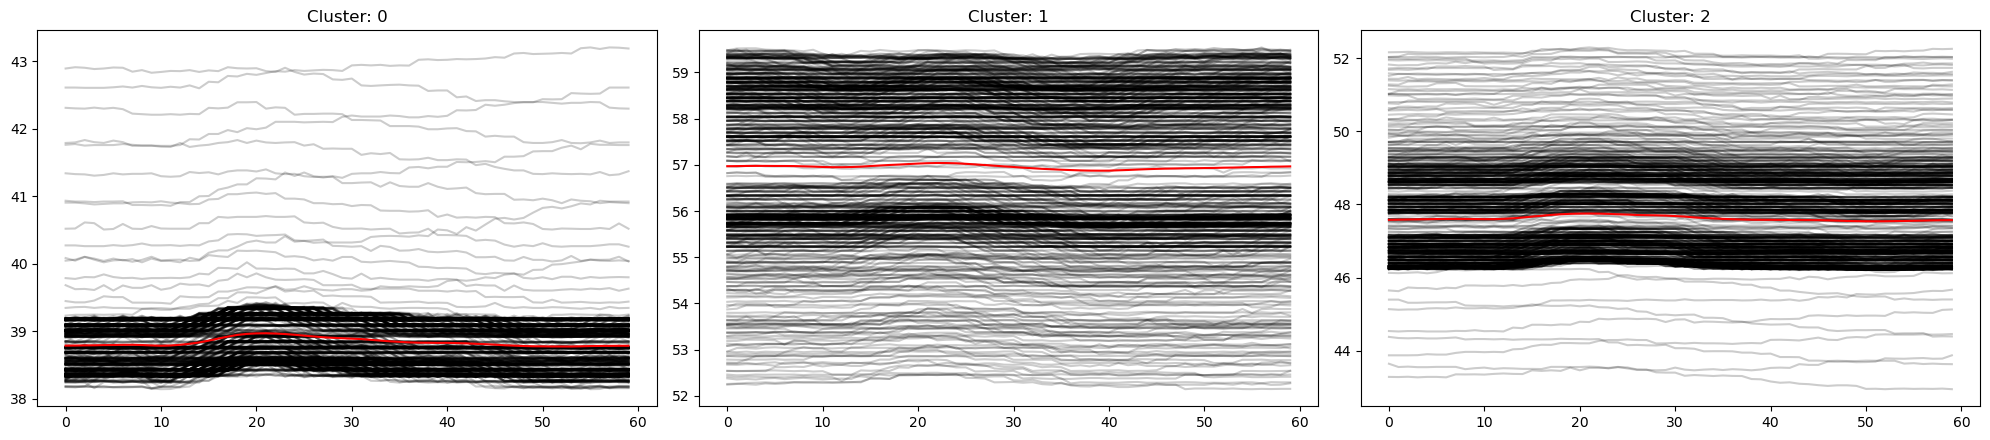

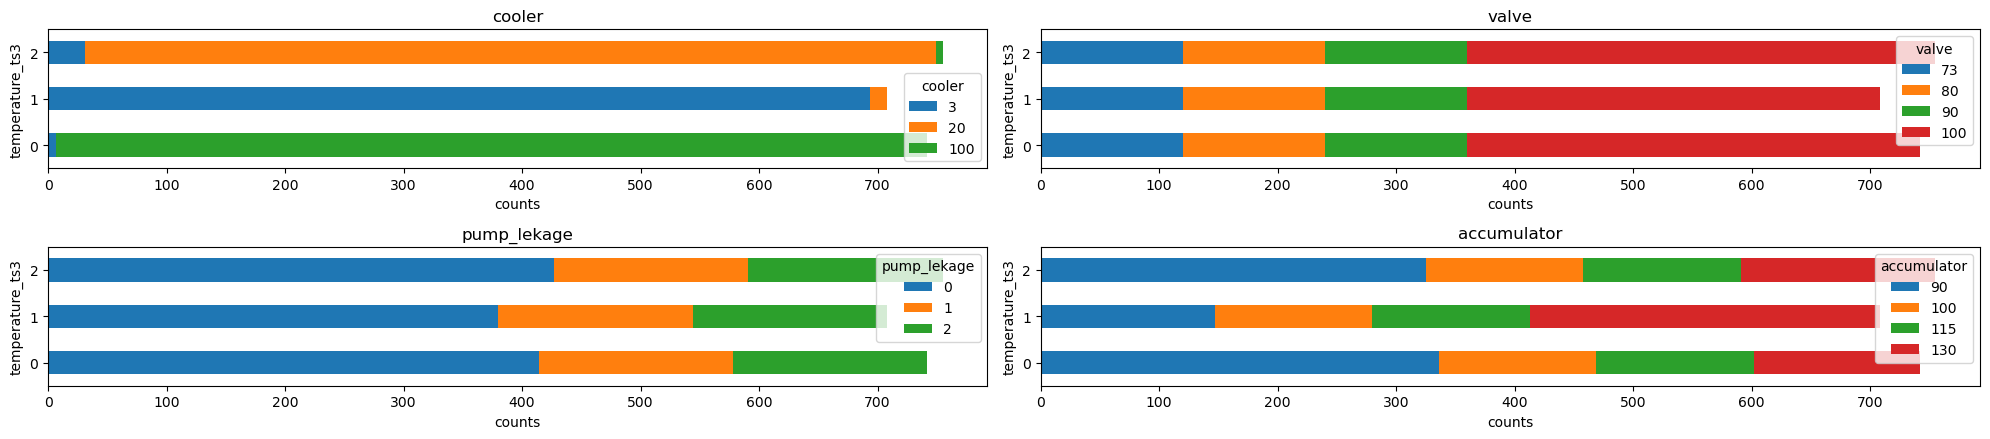

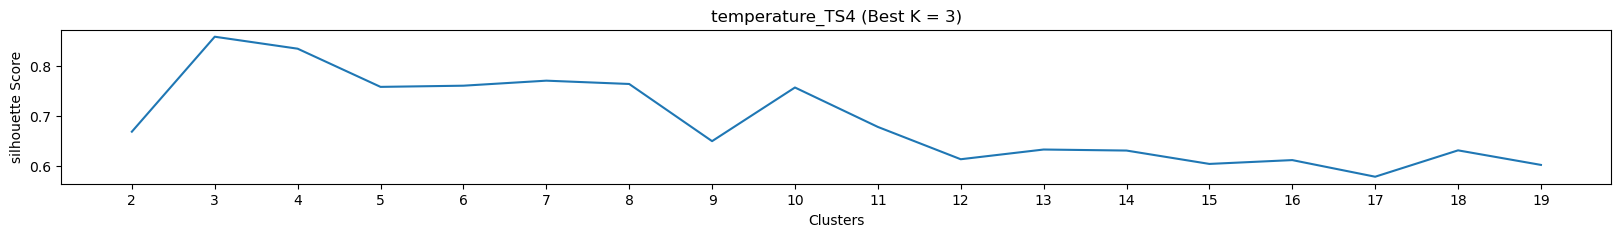

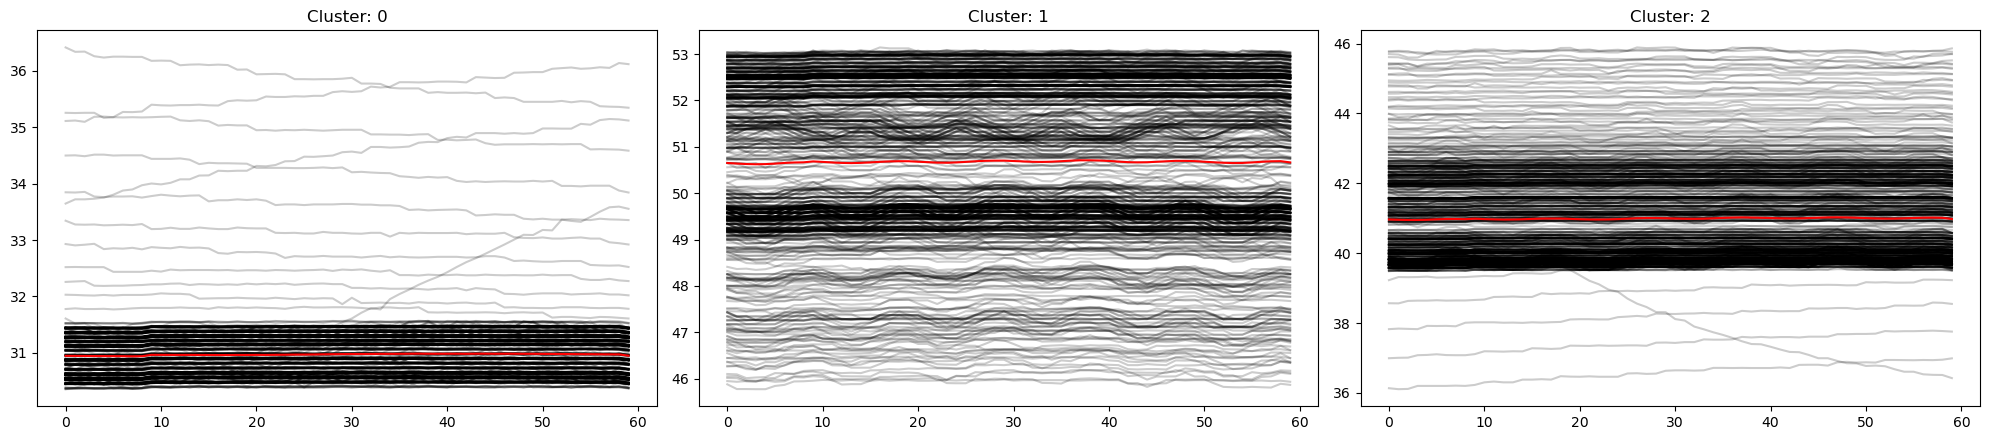

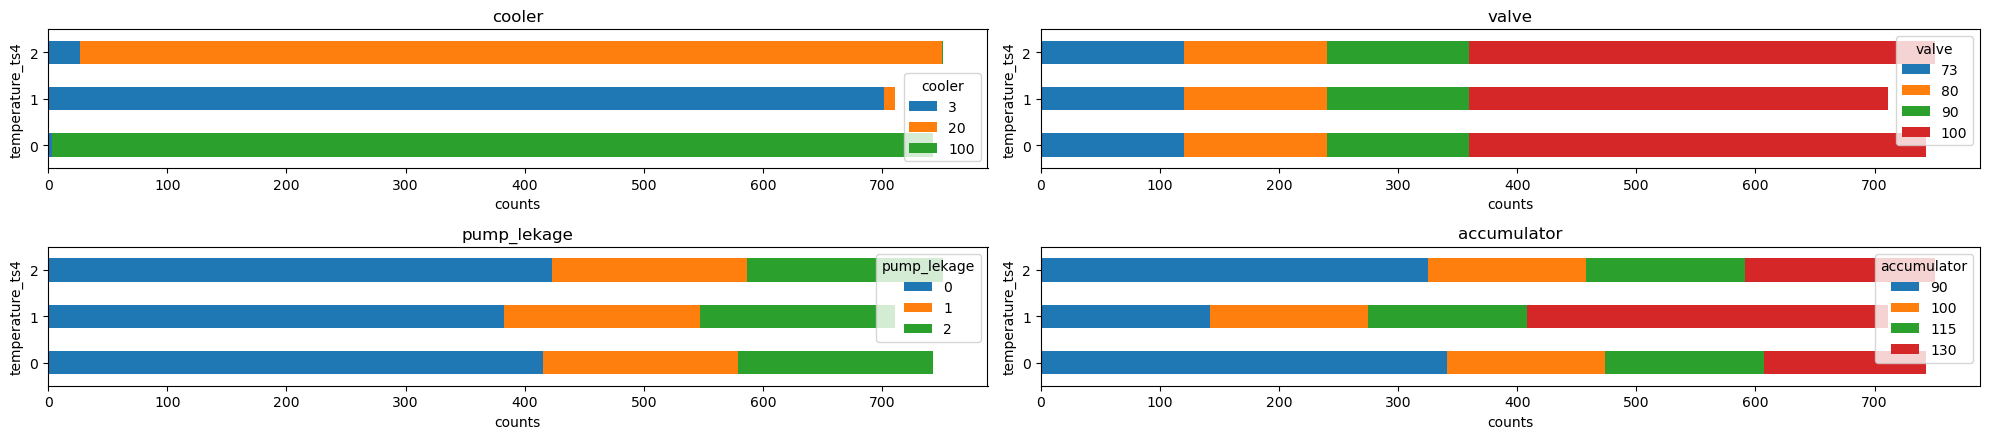

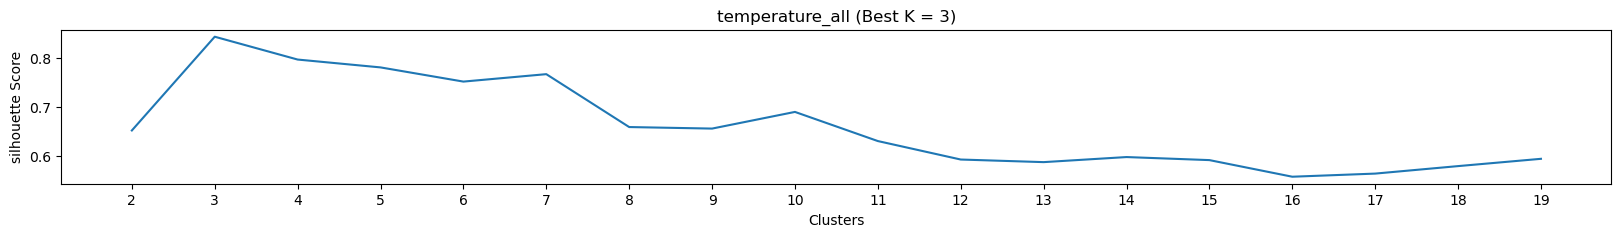

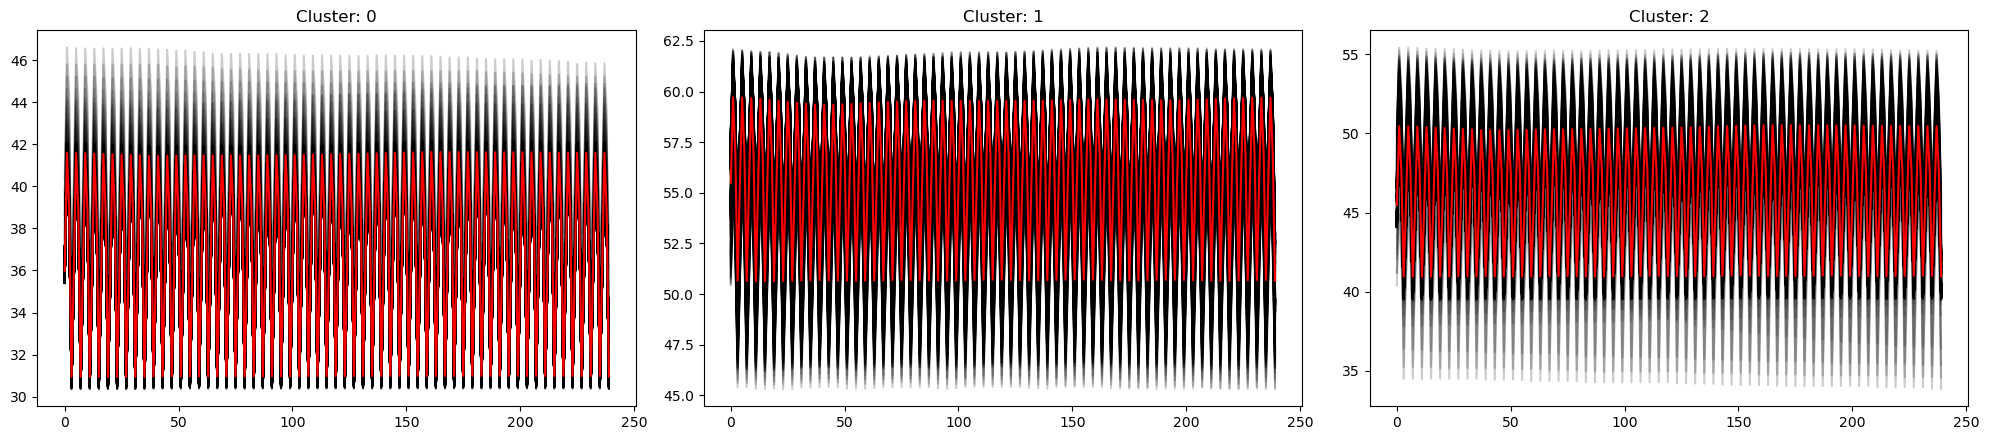

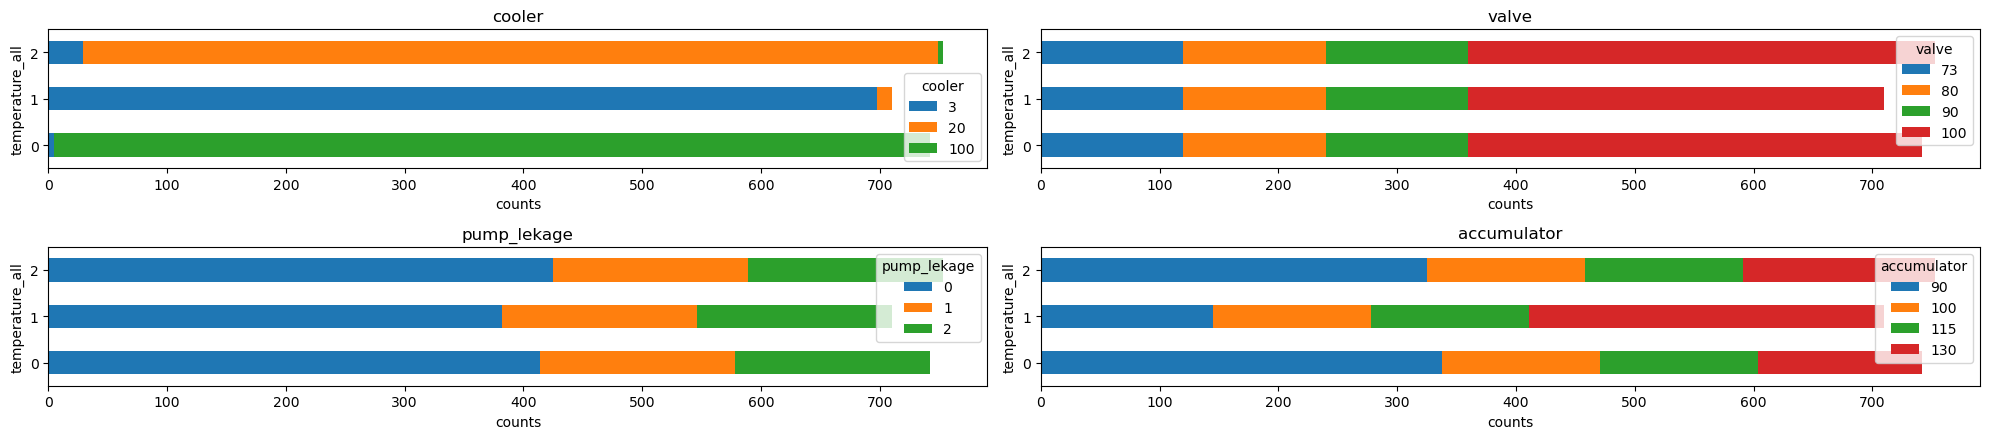

In [5]:
sensor_type = 'temperature'
cluster_models = {}
for sensor_name, data_array_ in ts_data_array[sensor_type].items():
    # fit kmeans cluster for ts array which best k( it identifies best K internally.)
    cluster_models[sensor_name] = ts_cluster_with_best_k(data_array_, sensor_name)
    plot_cluster_shapes(data_array_, cluster_models[sensor_name])
    # updating target data table with identified clusters
    target[f'{sensor_name.lower()}'] = cluster_models[sensor_name].labels_
    plot_target_counts_in_cluster(target, f'{sensor_name.lower()}')

All Temperature sensors are helpfull for predicting cooler condition.

### Pressure

/var/folders/nd/m4x9_d057f53cz89vtzdcwr40000gn/T/ipykernel_27407/152201337.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2,2, figsize=(20,4.5))


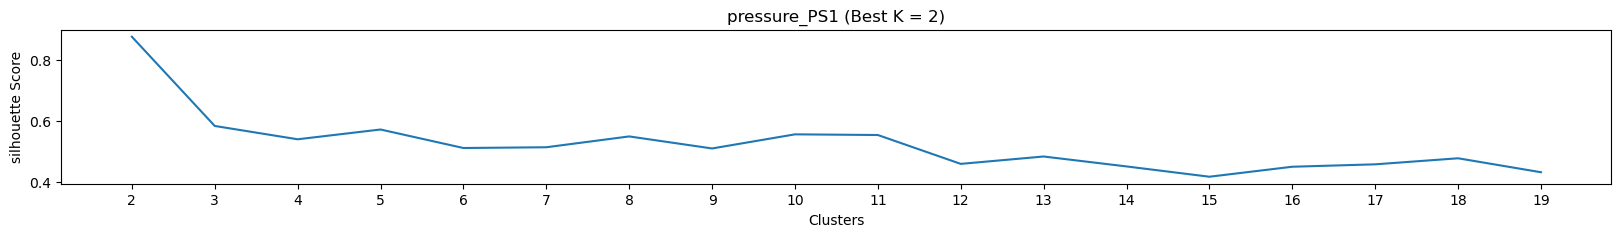

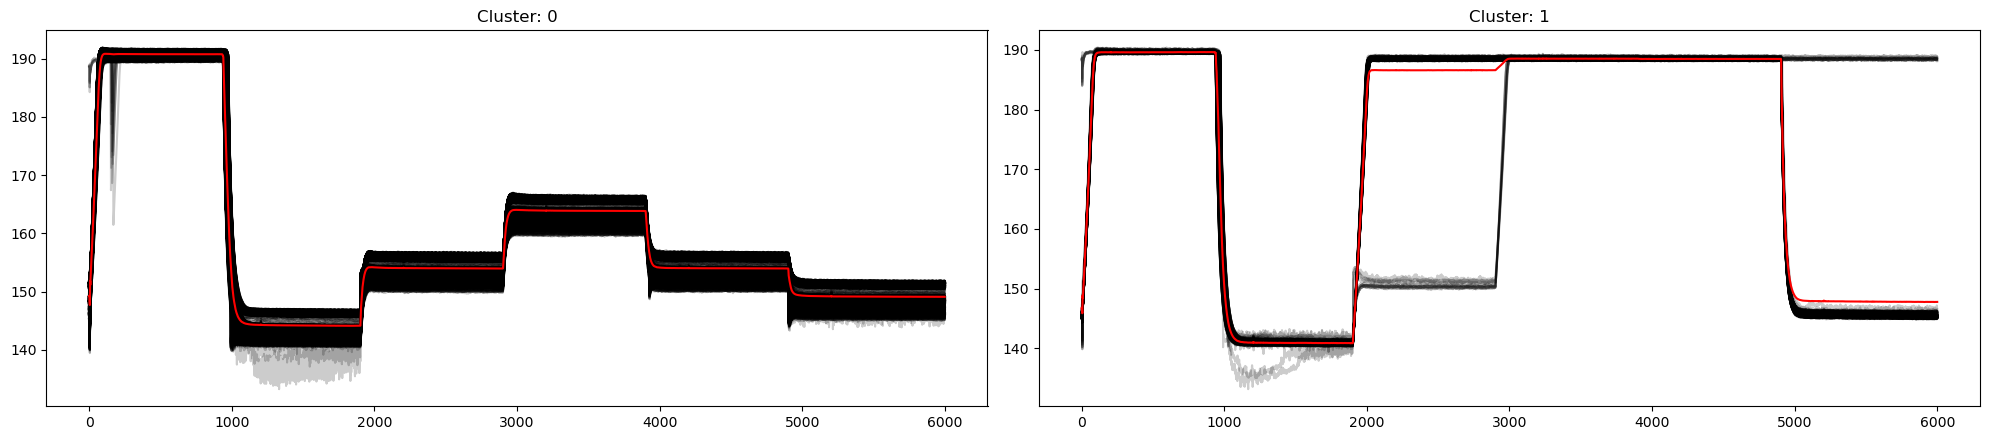

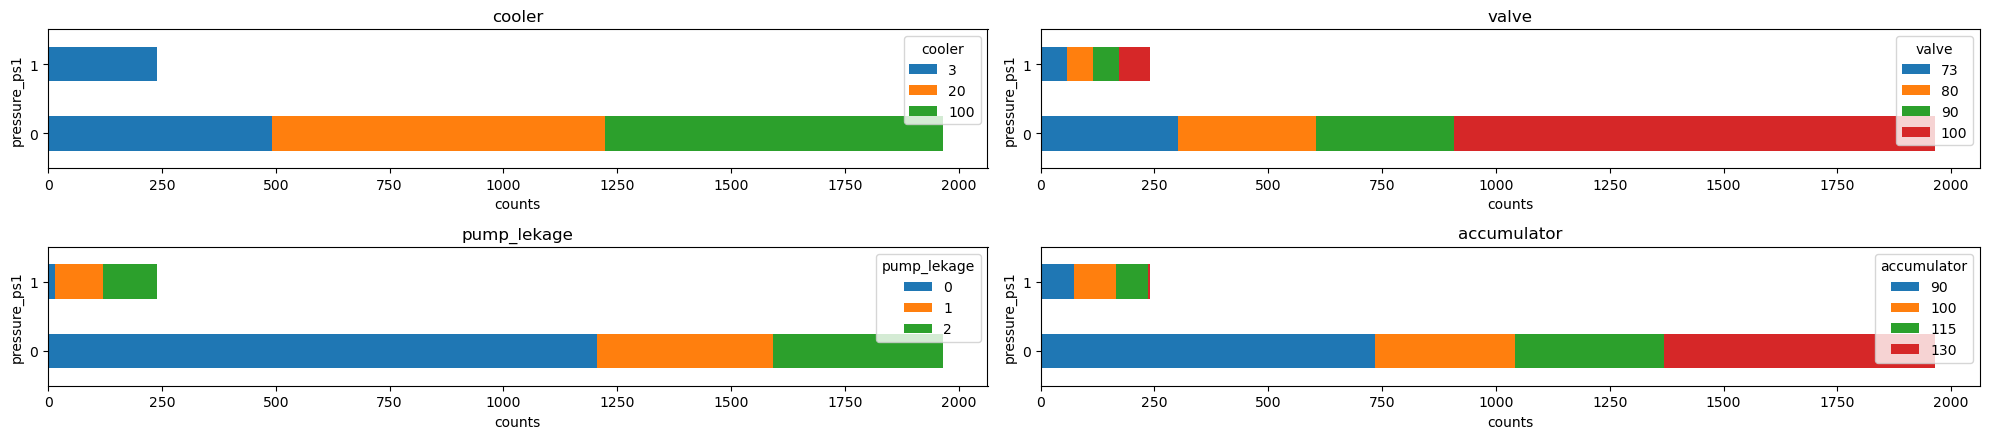

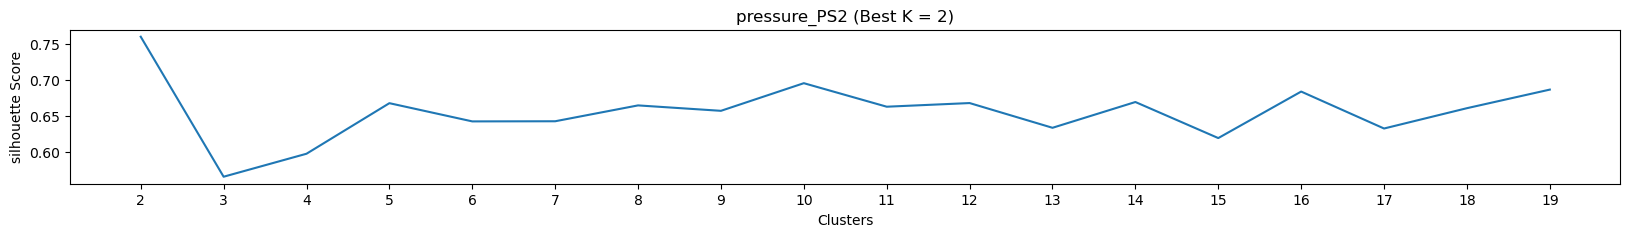

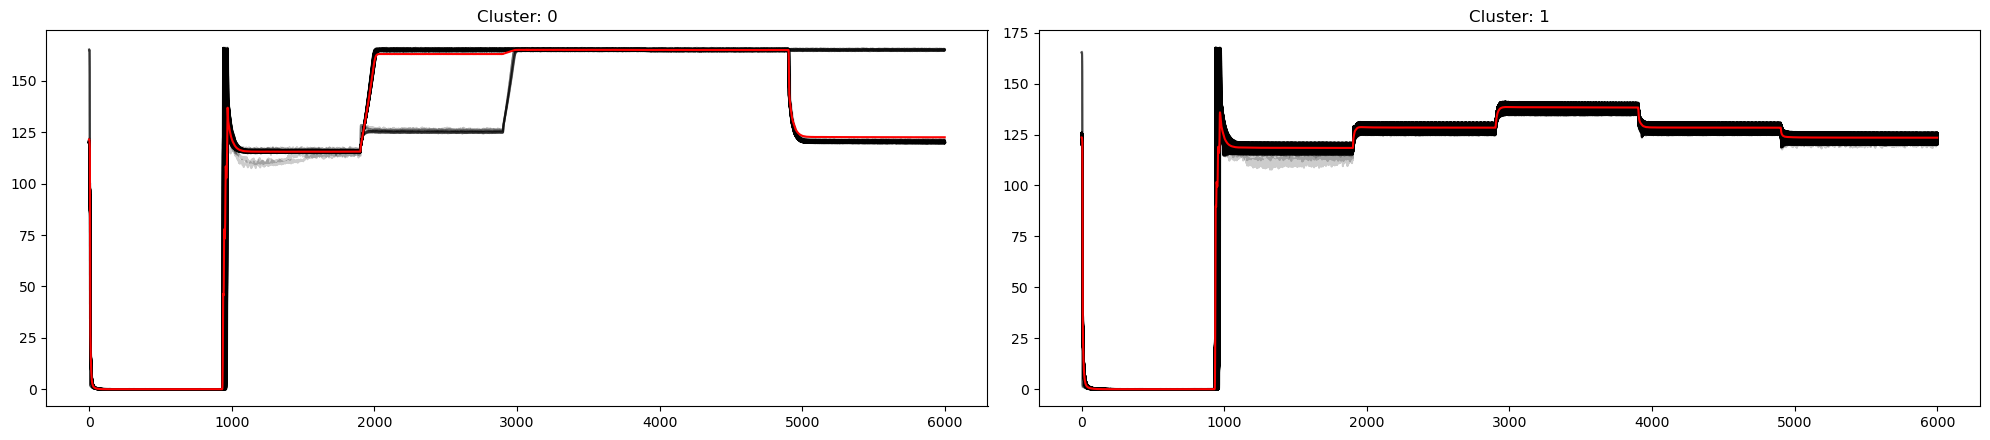

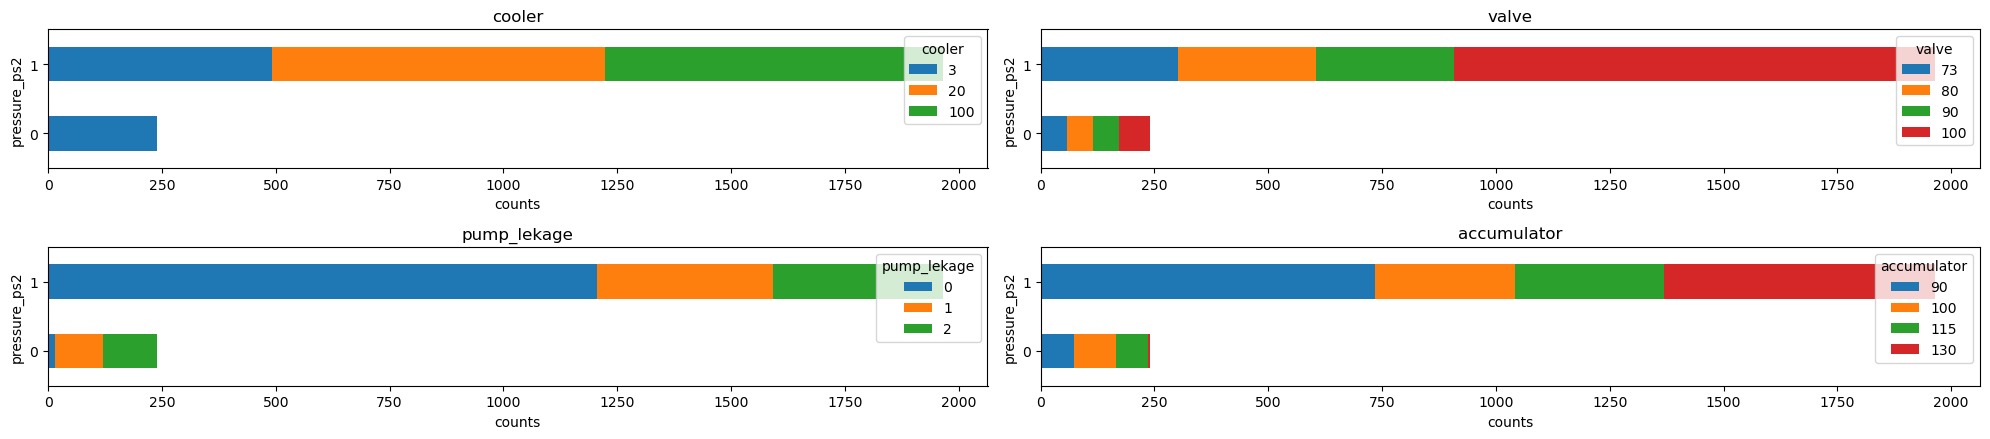

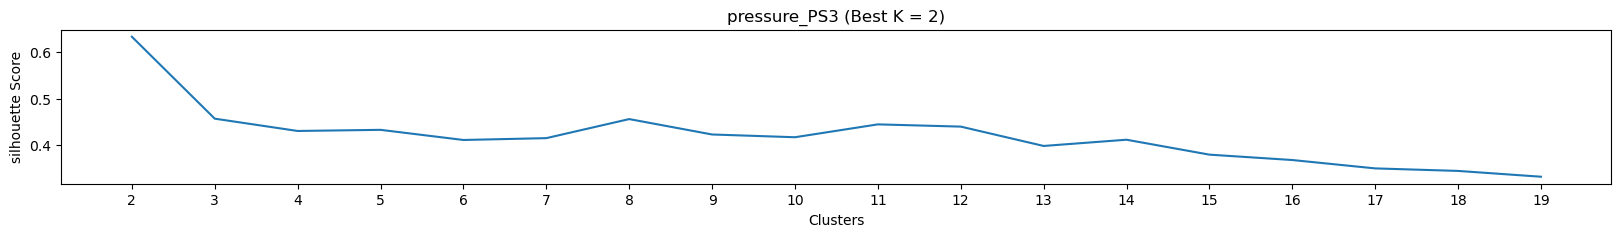

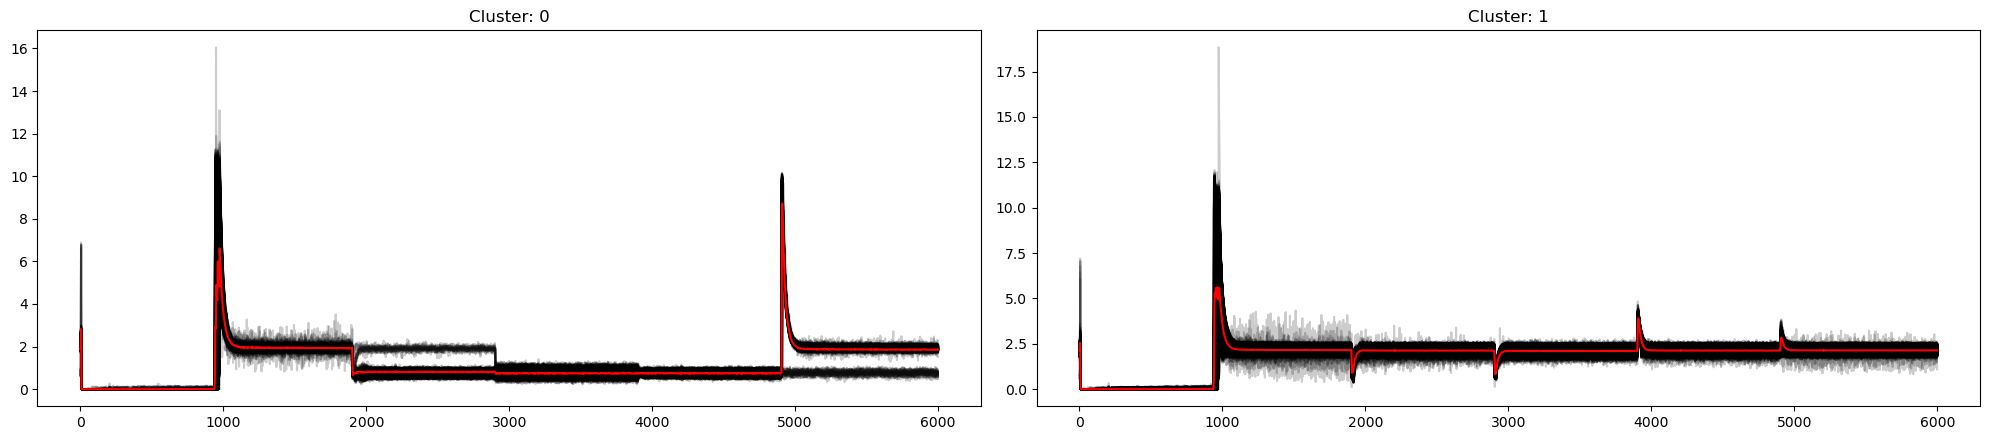

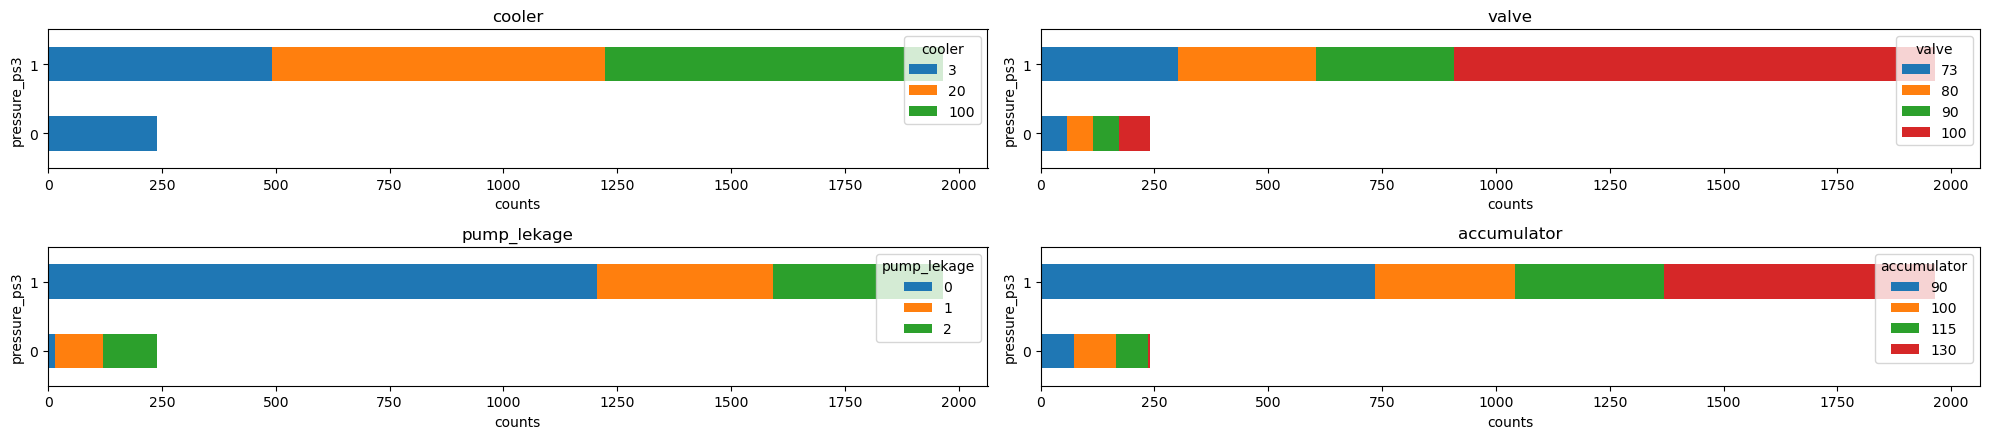

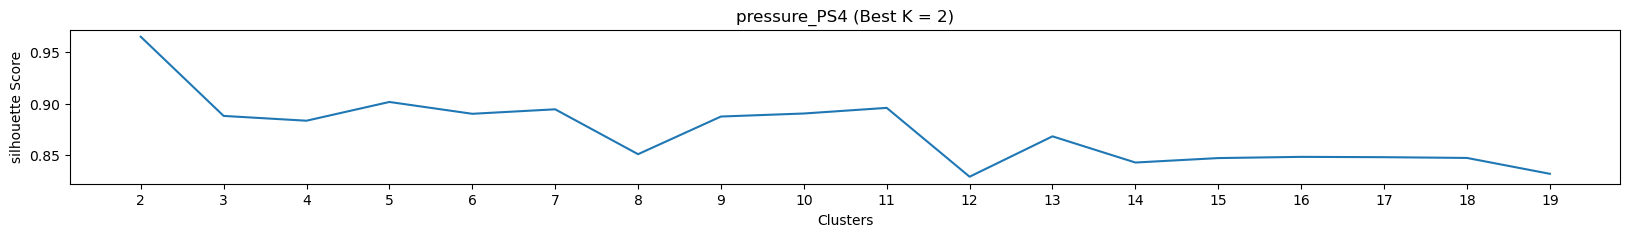

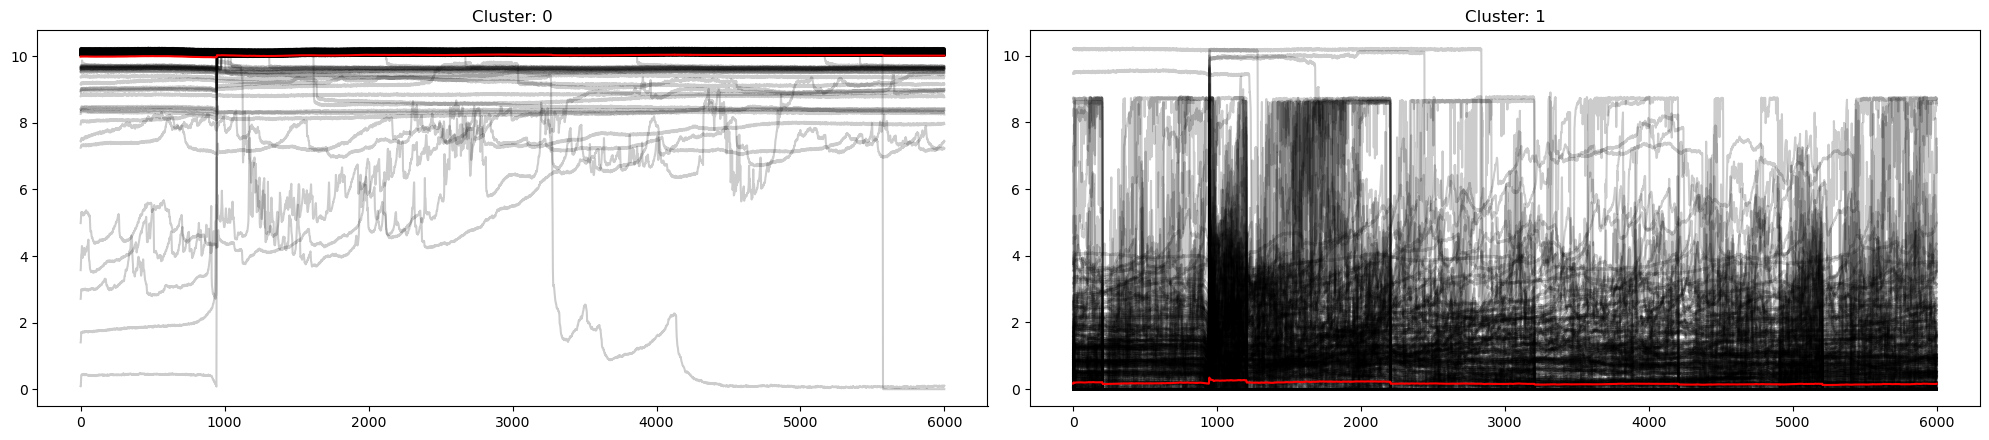

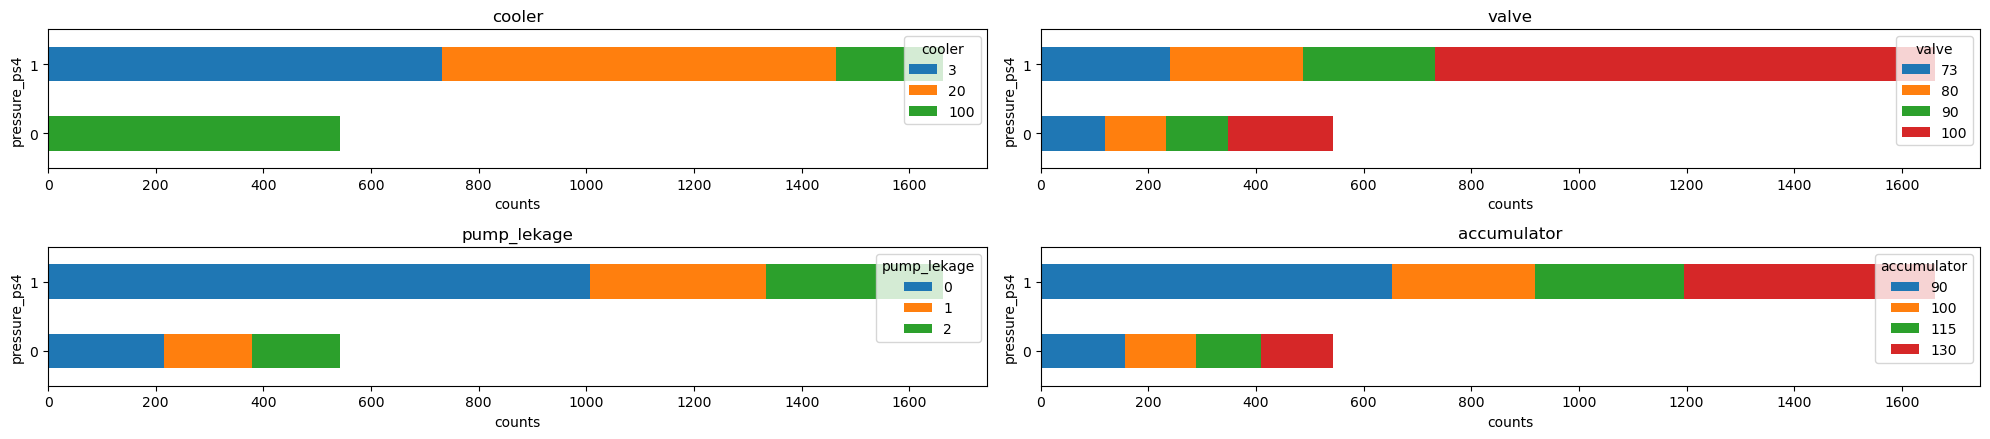

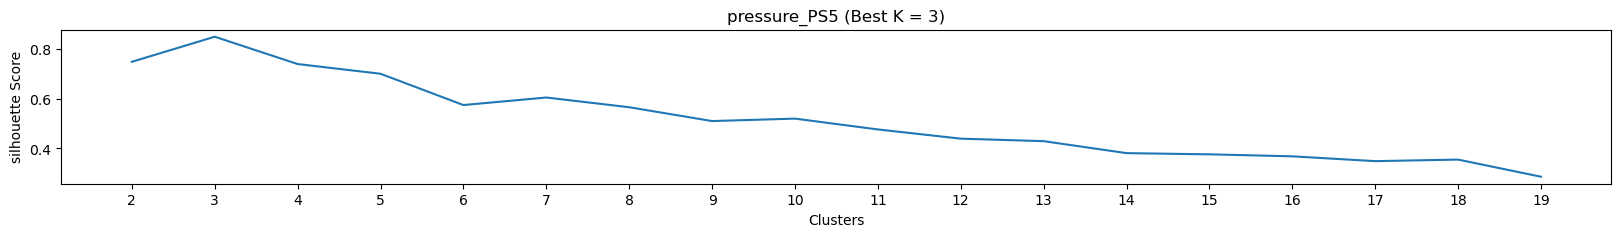

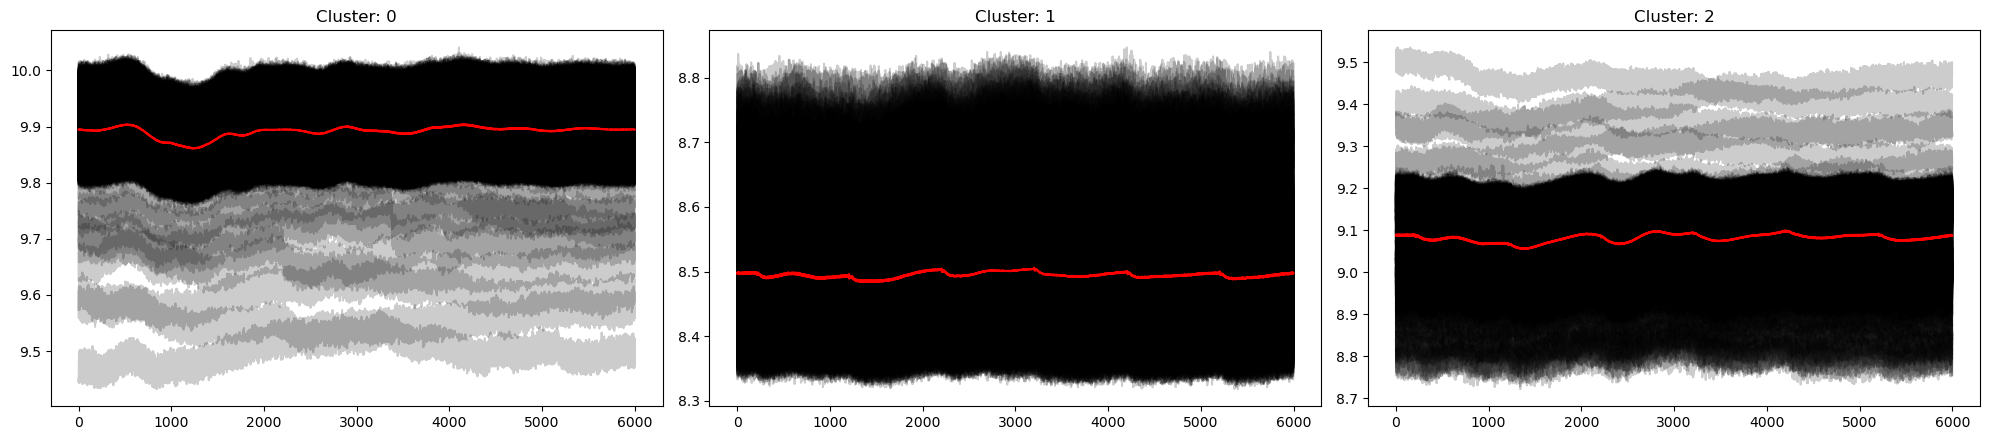

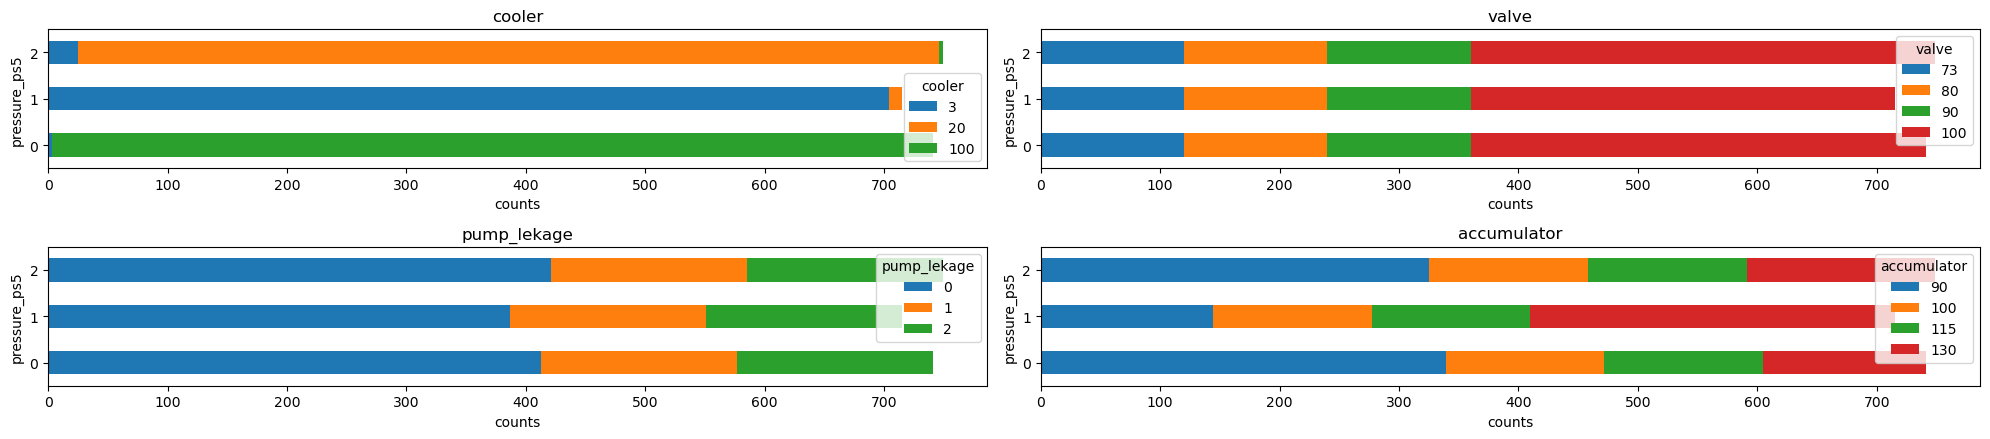

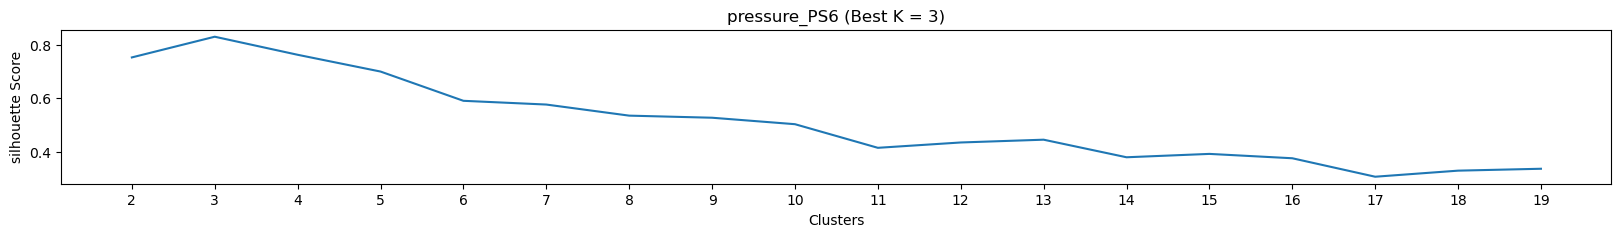

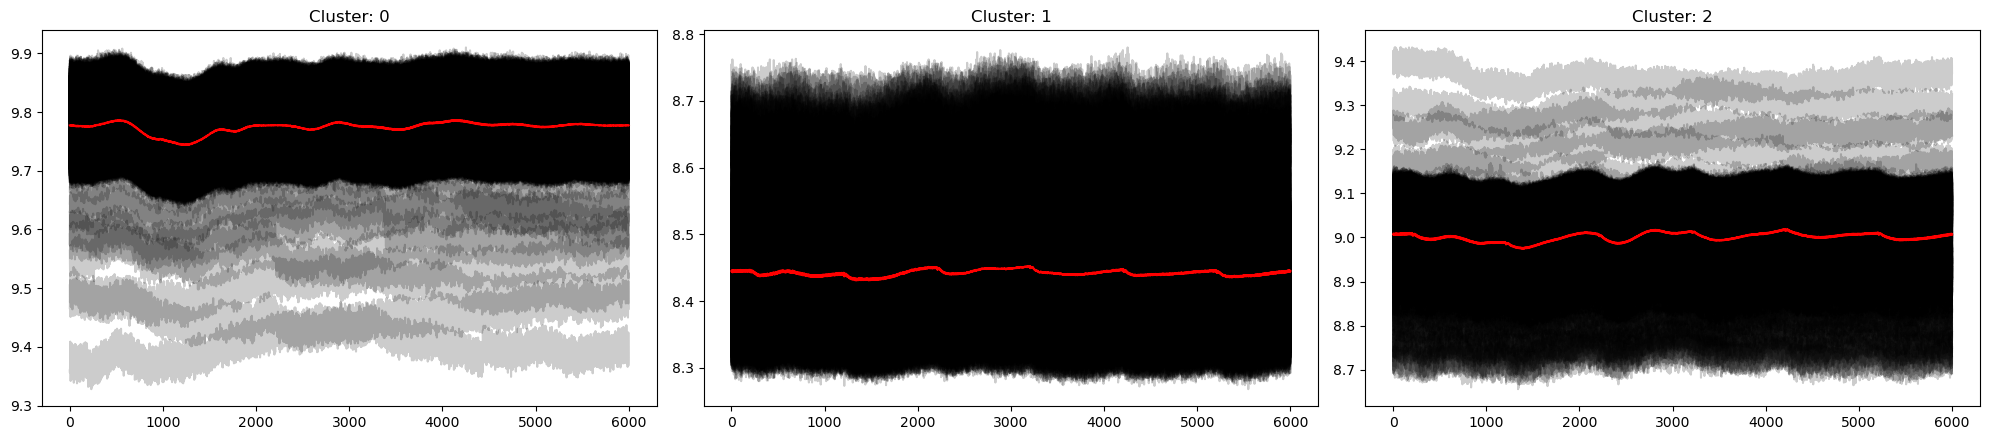

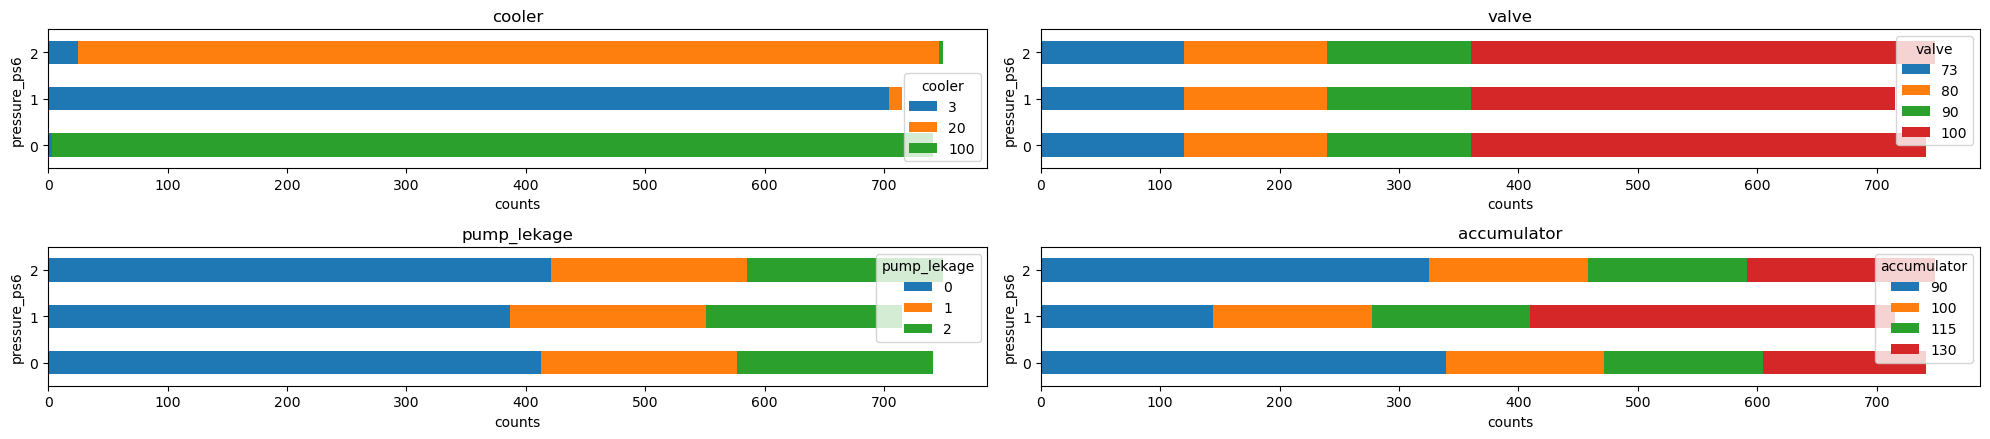

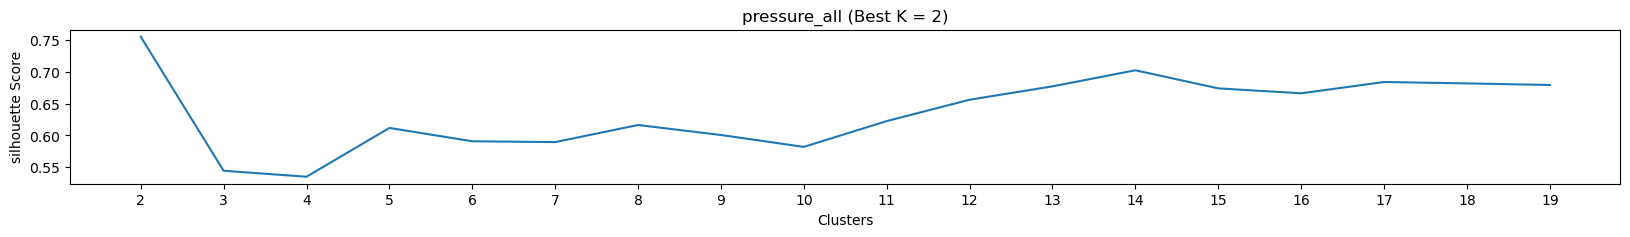

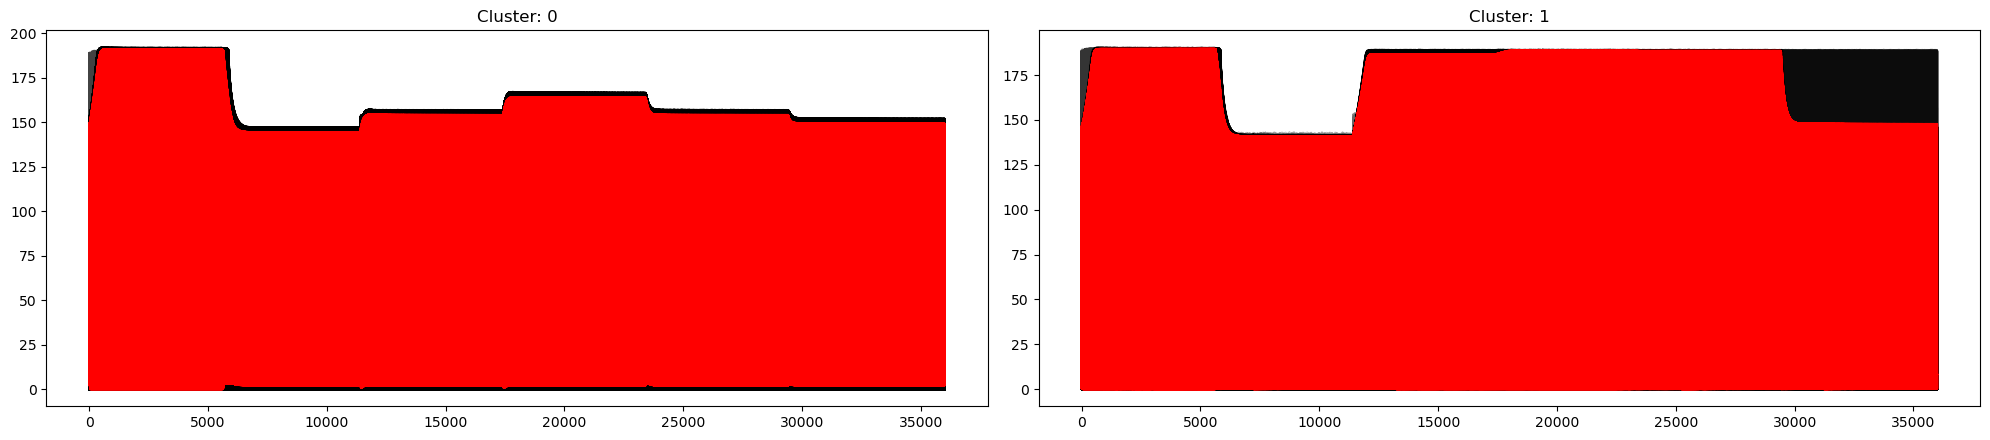

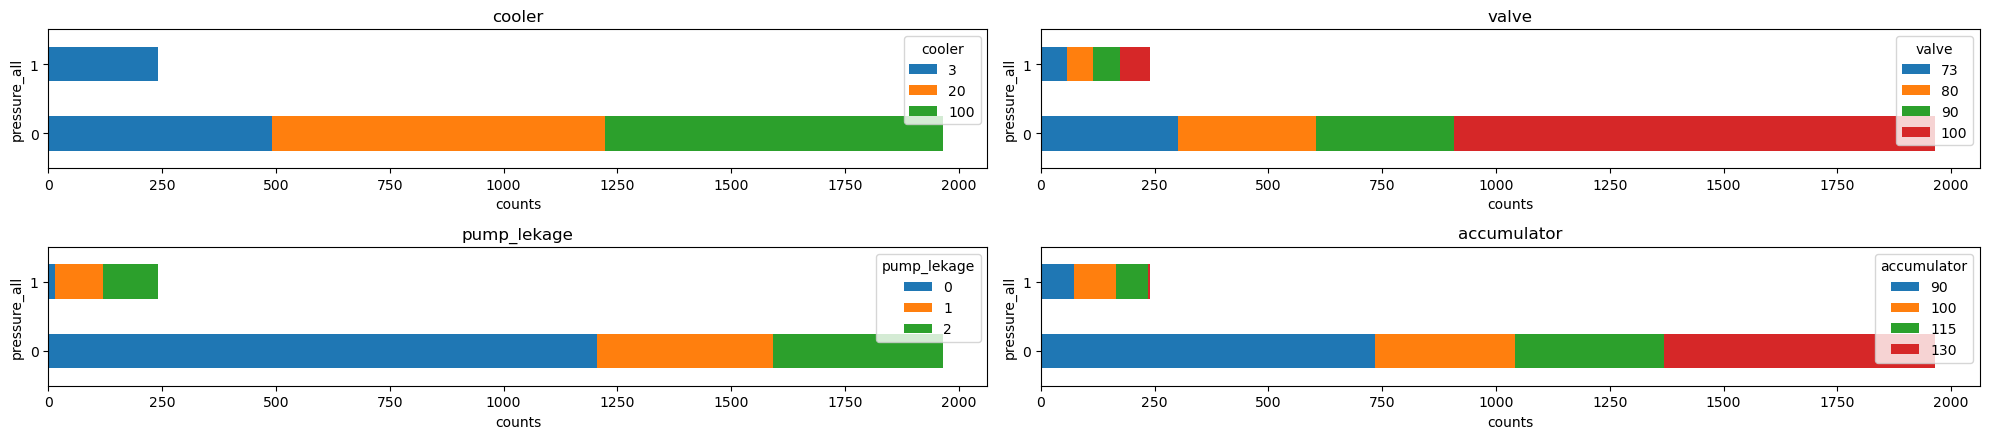

In [6]:
sensor_type = 'pressure'
cluster_models = {}
for sensor_name, data_array_ in ts_data_array[sensor_type].items():
    # fit kmeans cluster for ts array which best k( it identifies best K internally.)
    cluster_models[sensor_name] = ts_cluster_with_best_k(data_array_, sensor_name)
    plot_cluster_shapes(data_array_, cluster_models[sensor_name])
    # updating target data table with identified clusters
    target[f'{sensor_name.lower()}'] = cluster_models[sensor_name].labels_
    plot_target_counts_in_cluster(target, f'{sensor_name.lower()}')

### Motor Power

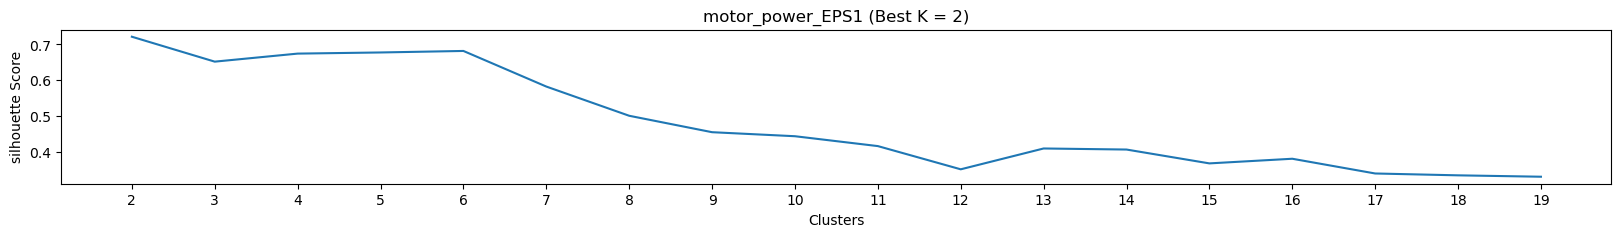

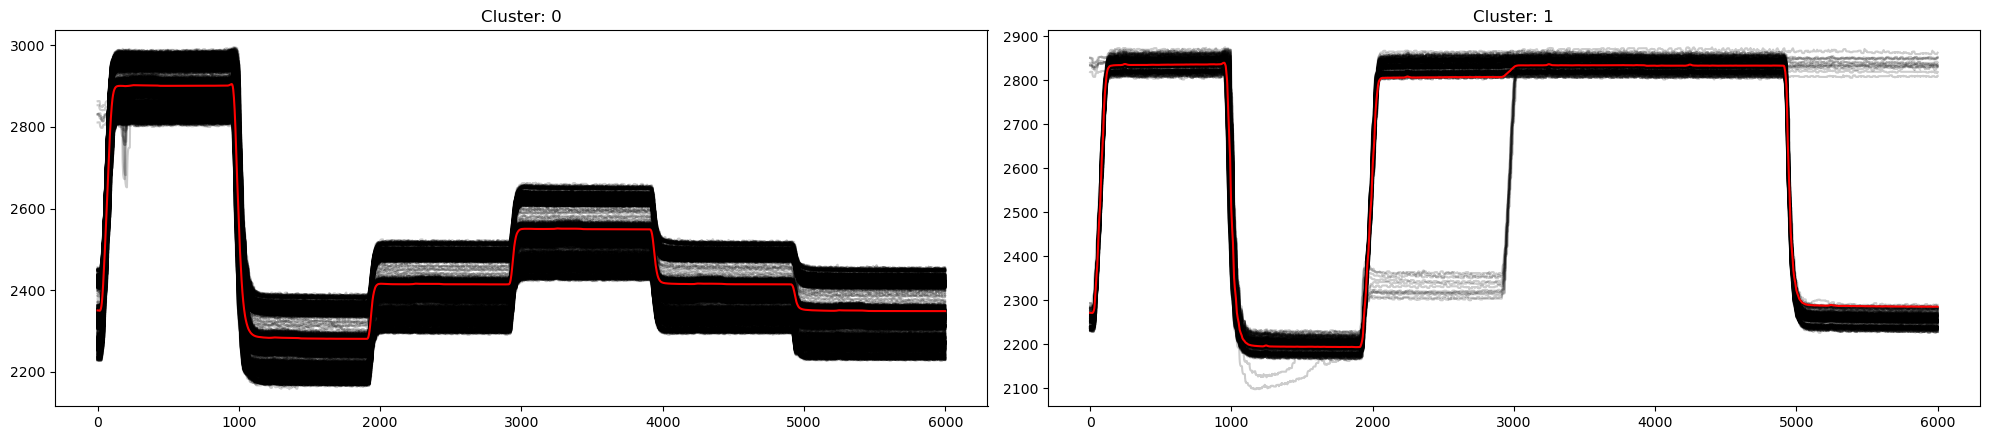

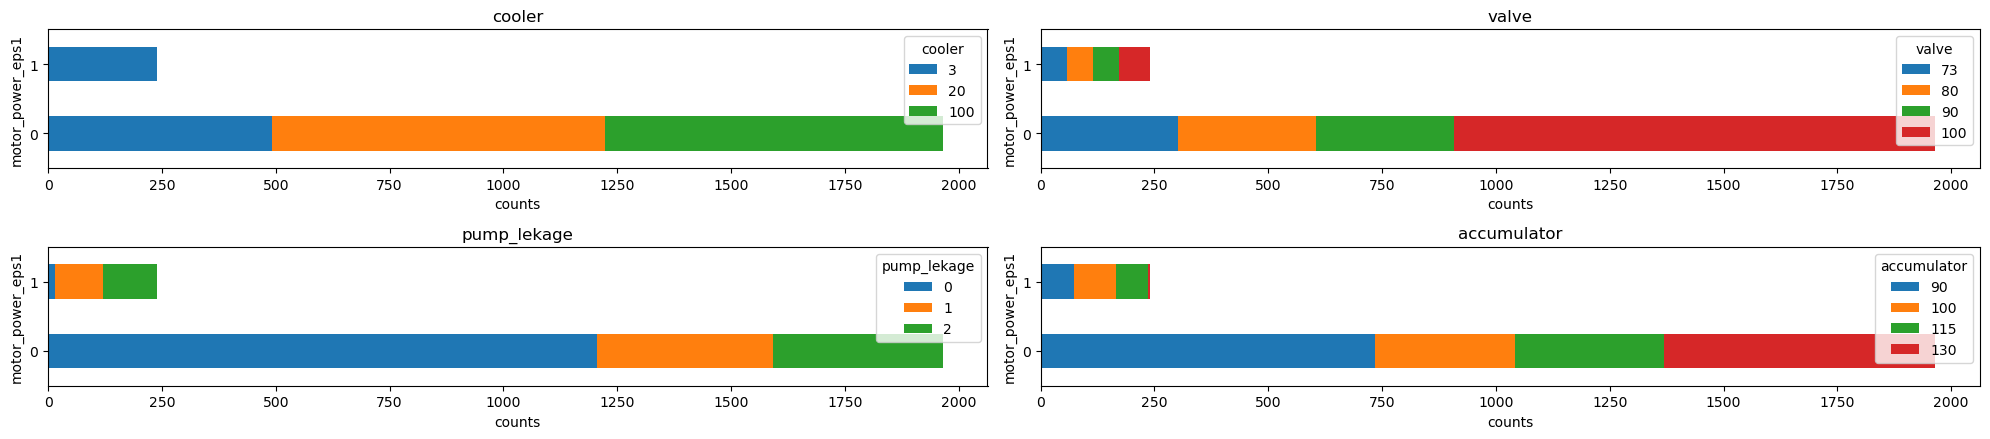

In [7]:
sensor_type = 'motor_power'
cluster_models = {}
for sensor_name, data_array_ in ts_data_array[sensor_type].items():
    # fit kmeans cluster for ts array which best k( it identifies best K internally.)
    cluster_models[sensor_name] = ts_cluster_with_best_k(data_array_, sensor_name)
    plot_cluster_shapes(data_array_, cluster_models[sensor_name])
    # updating target data table with identified clusters
    target[f'{sensor_name.lower()}'] = cluster_models[sensor_name].labels_
    plot_target_counts_in_cluster(target, f'{sensor_name.lower()}')

### Volume Flow

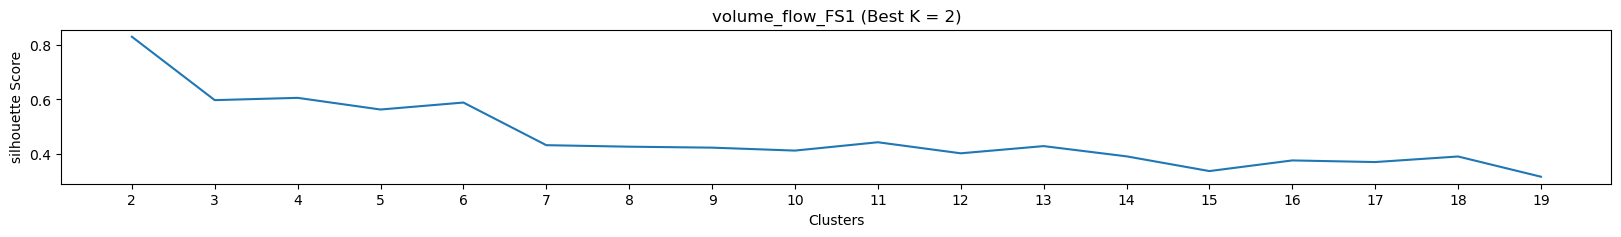

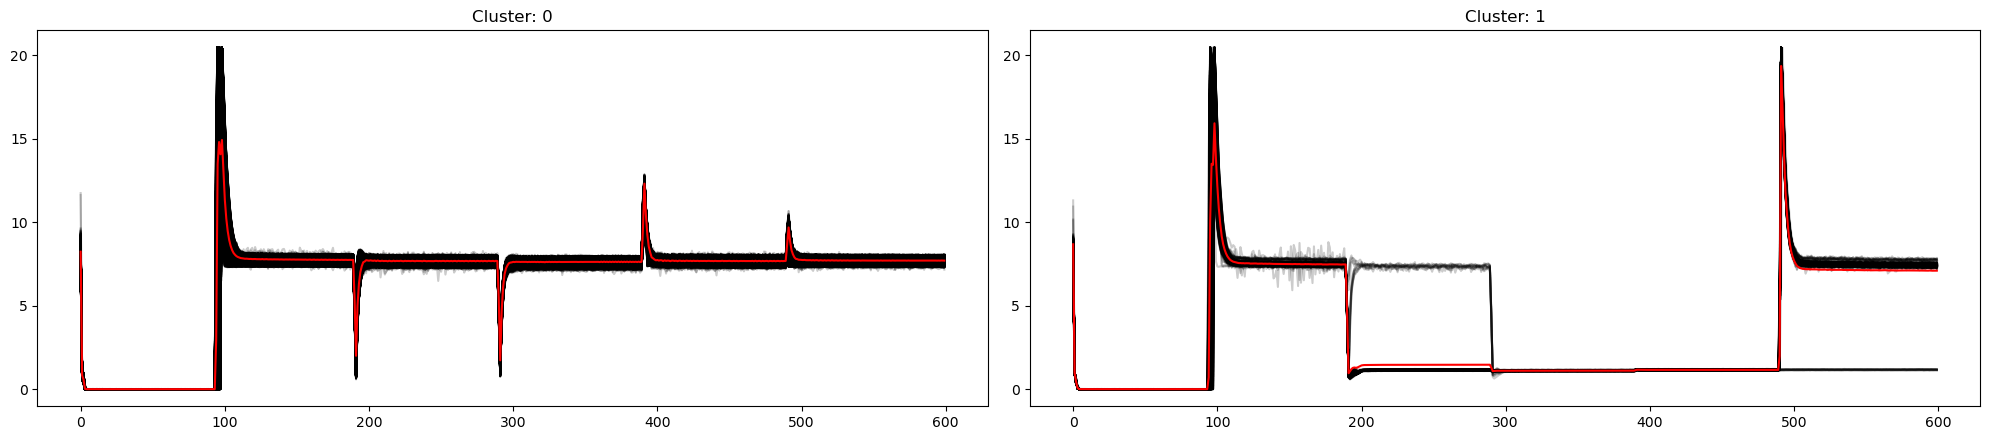

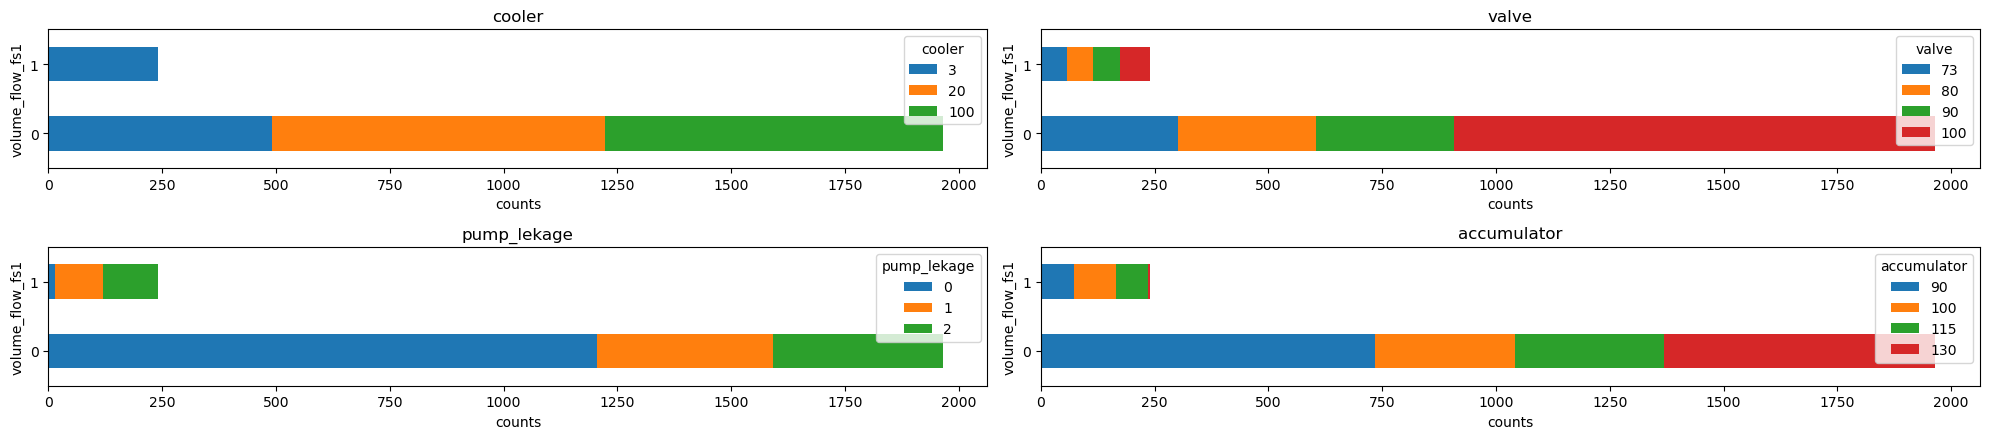

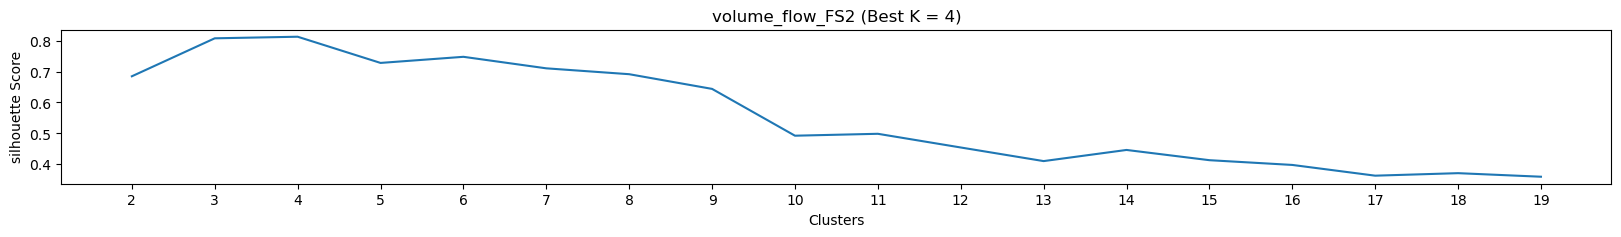

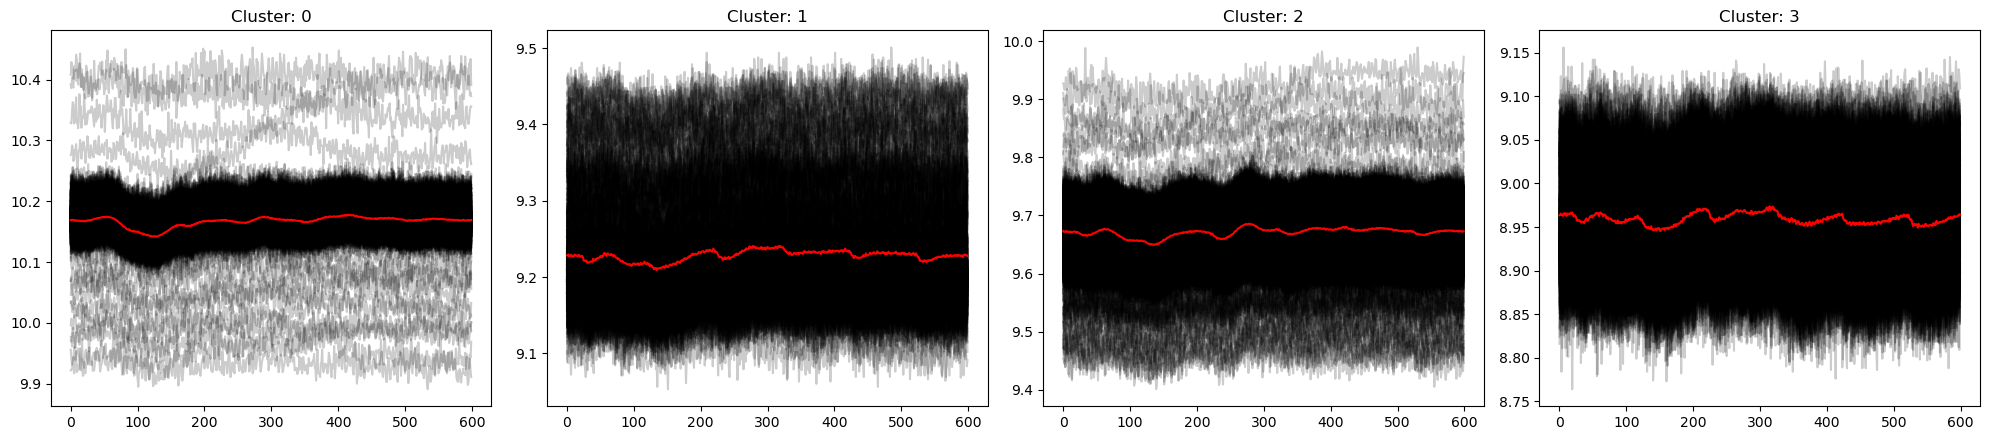

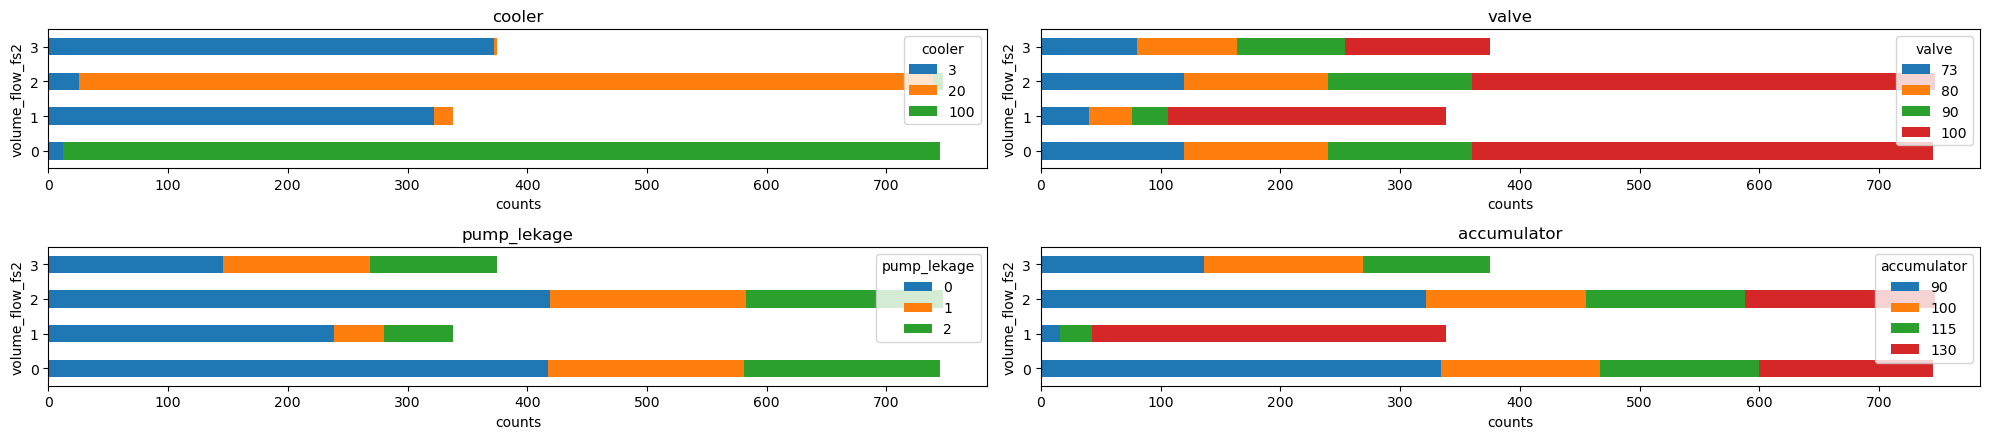

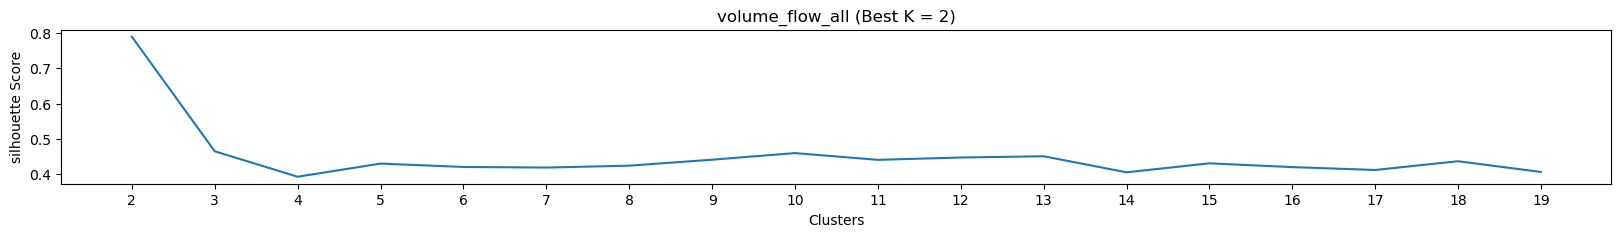

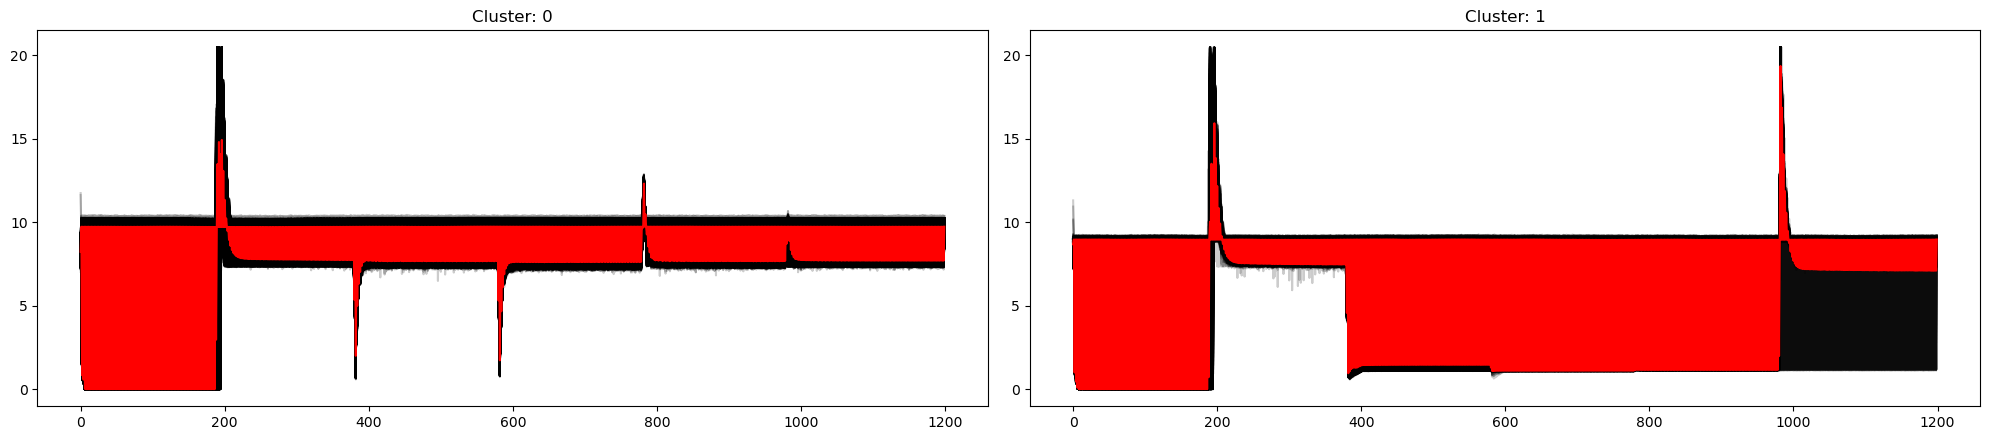

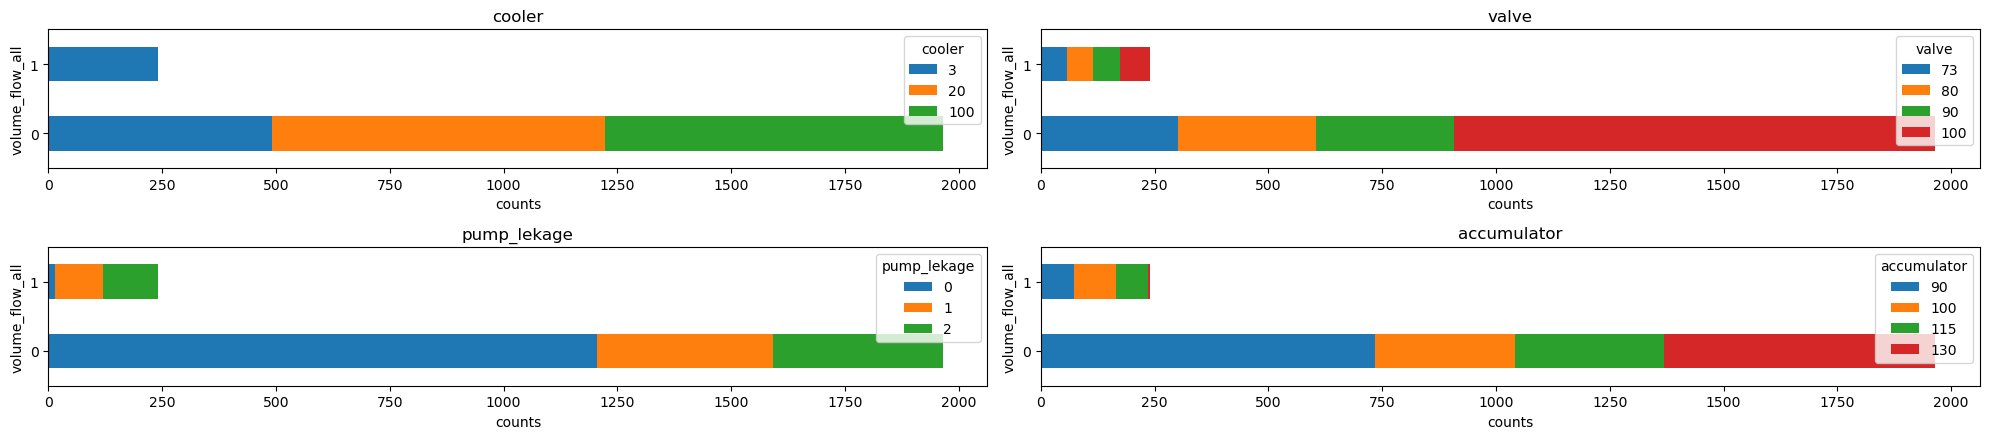

In [8]:
sensor_type = 'volume_flow'
cluster_models = {}
for sensor_name, data_array_ in ts_data_array[sensor_type].items():
    # fit kmeans cluster for ts array which best k( it identifies best K internally.)
    cluster_models[sensor_name] = ts_cluster_with_best_k(data_array_, sensor_name)
    plot_cluster_shapes(data_array_, cluster_models[sensor_name])
    # updating target data table with identified clusters
    target[f'{sensor_name.lower()}'] = cluster_models[sensor_name].labels_
    plot_target_counts_in_cluster(target, f'{sensor_name.lower()}')

### Vibration

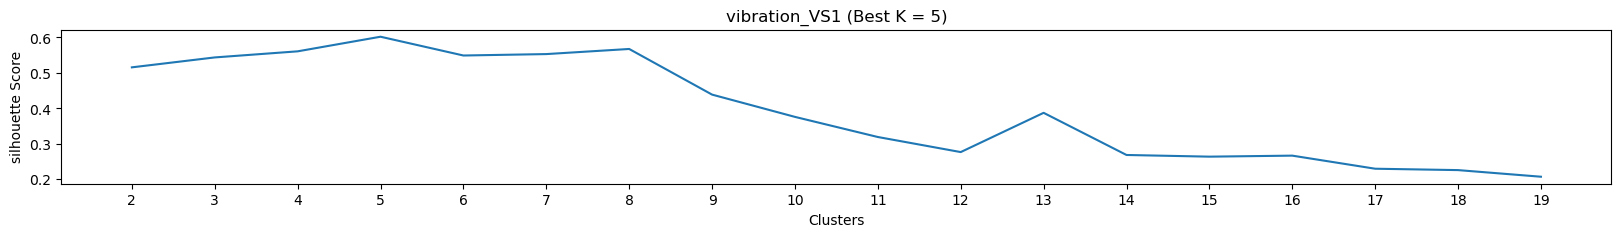

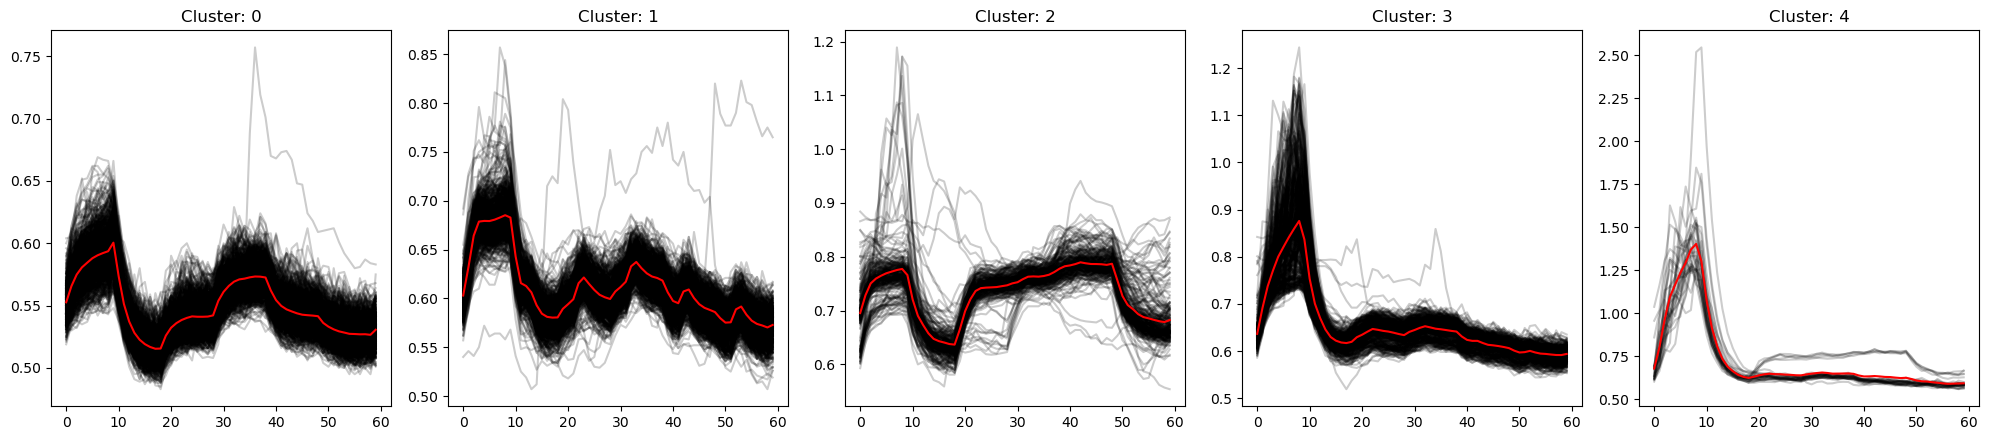

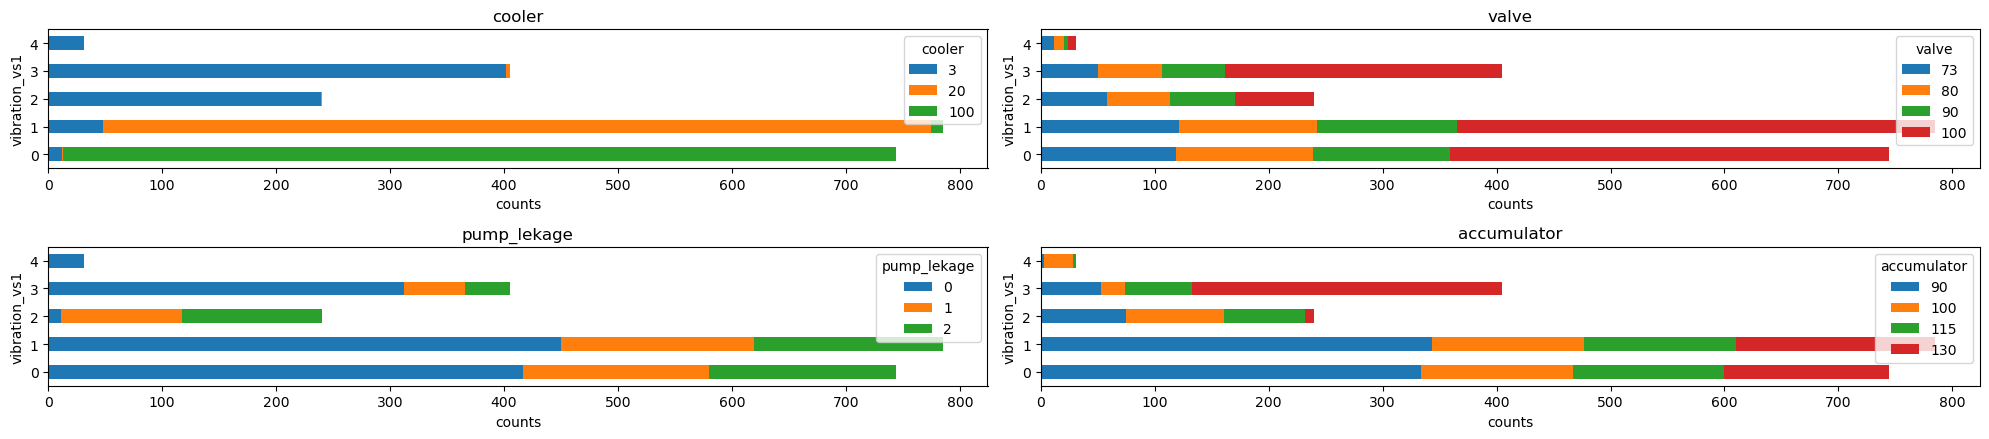

In [9]:
sensor_type = 'vibration'
cluster_models = {}
for sensor_name, data_array_ in ts_data_array[sensor_type].items():
    # fit kmeans cluster for ts array which best k( it identifies best K internally.)
    cluster_models[sensor_name] = ts_cluster_with_best_k(data_array_, sensor_name)
    plot_cluster_shapes(data_array_, cluster_models[sensor_name])
    # updating target data table with identified clusters
    target[f'{sensor_name.lower()}'] = cluster_models[sensor_name].labels_
    plot_target_counts_in_cluster(target, f'{sensor_name.lower()}')

### Cooling Efficiency

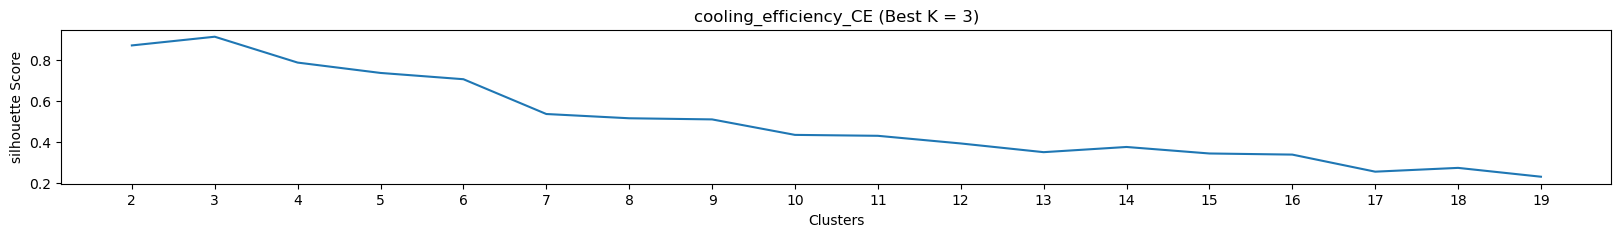

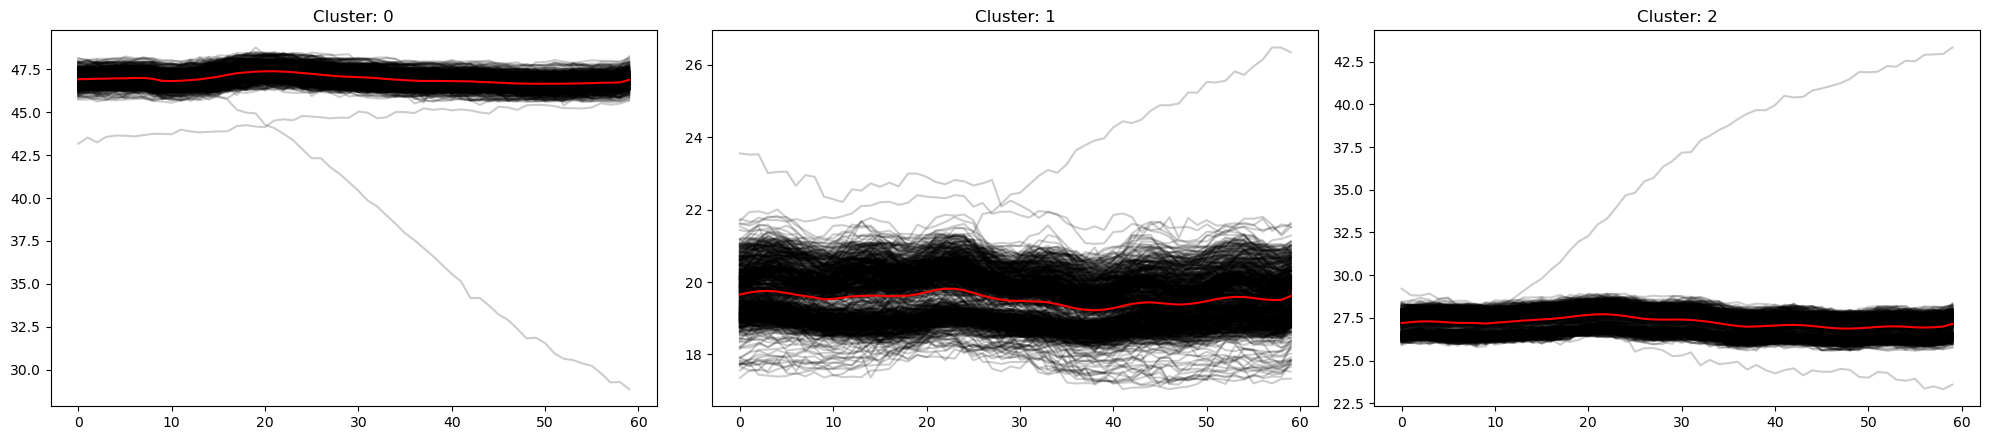

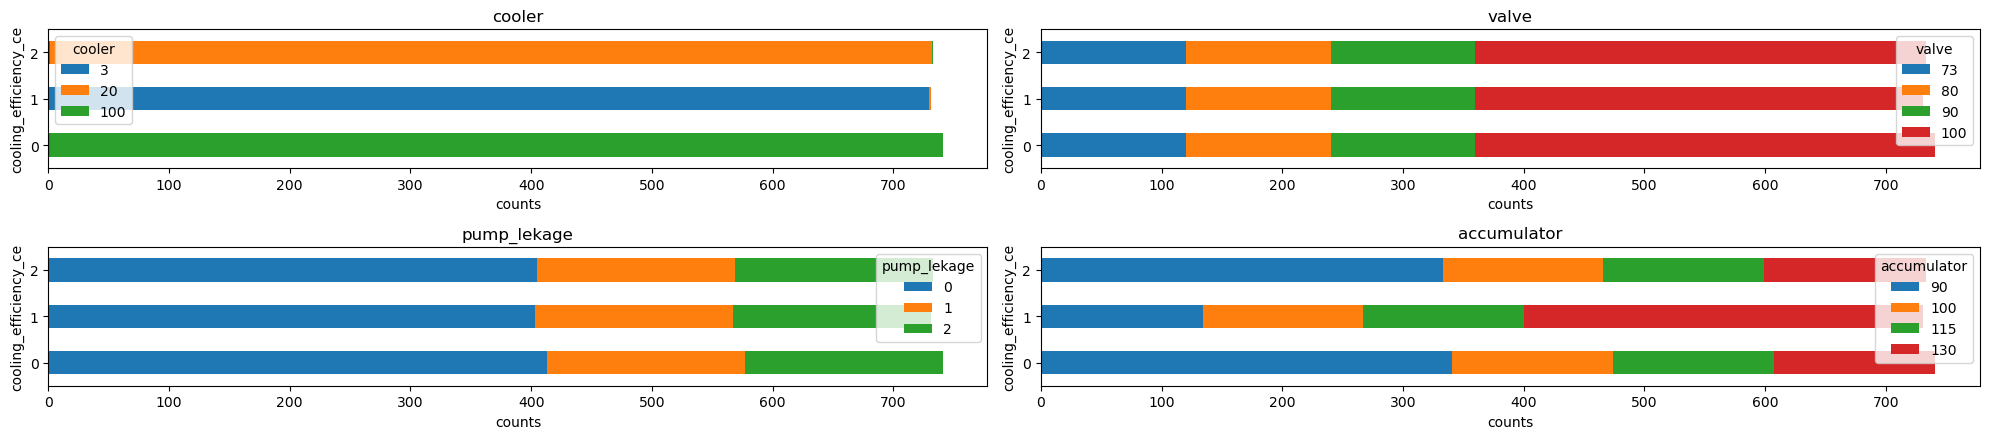

In [10]:
sensor_type = 'cooling_efficiency'
cluster_models = {}
for sensor_name, data_array_ in ts_data_array[sensor_type].items():
    # fit kmeans cluster for ts array which best k( it identifies best K internally.)
    cluster_models[sensor_name] = ts_cluster_with_best_k(data_array_, sensor_name)
    plot_cluster_shapes(data_array_, cluster_models[sensor_name])
    # updating target data table with identified clusters
    target[f'{sensor_name.lower()}'] = cluster_models[sensor_name].labels_
    plot_target_counts_in_cluster(target, f'{sensor_name.lower()}')

### Cooling Power

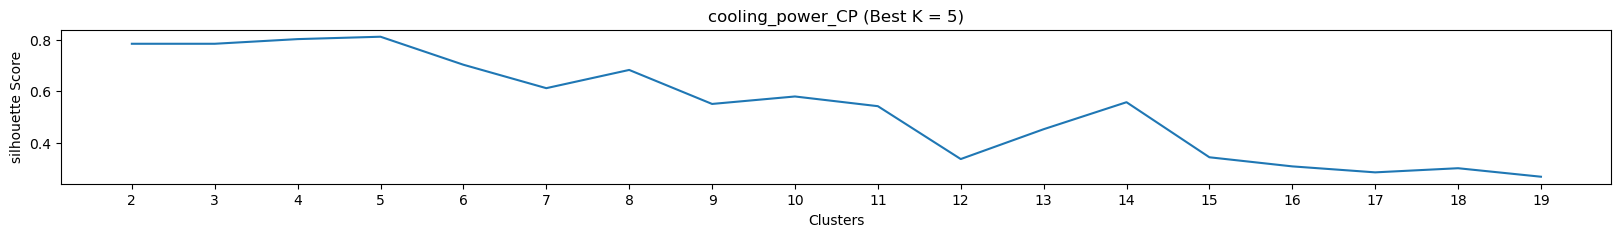

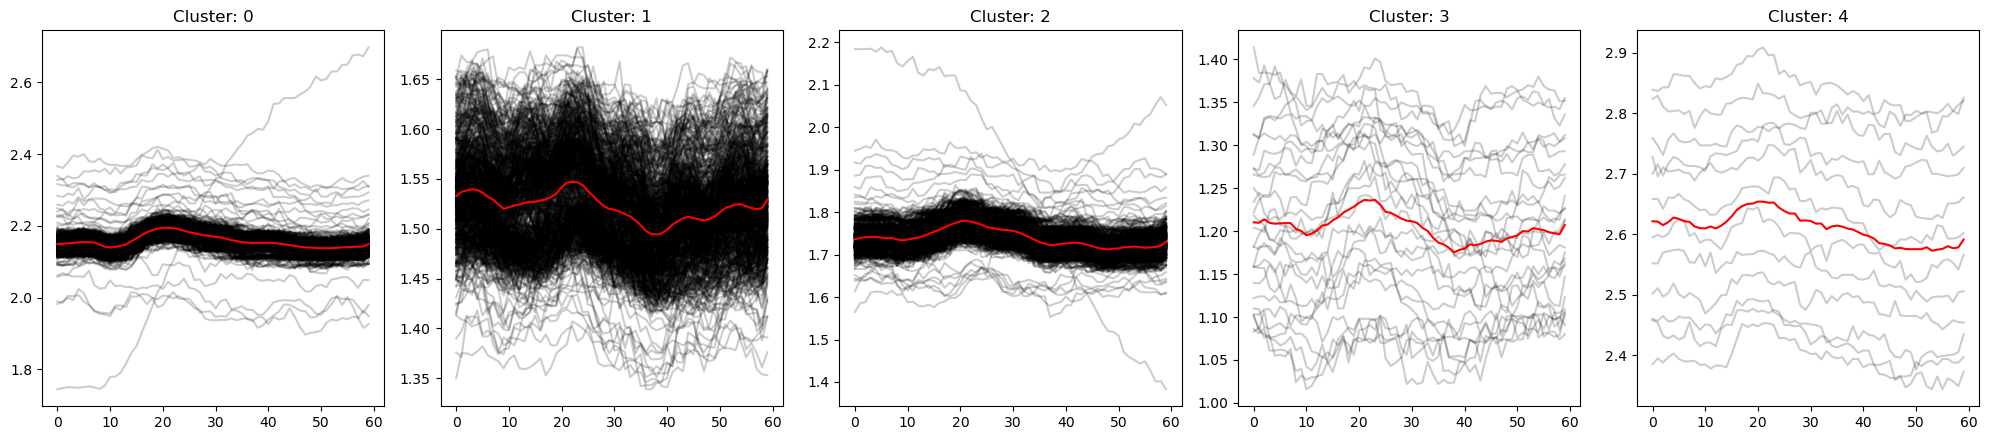

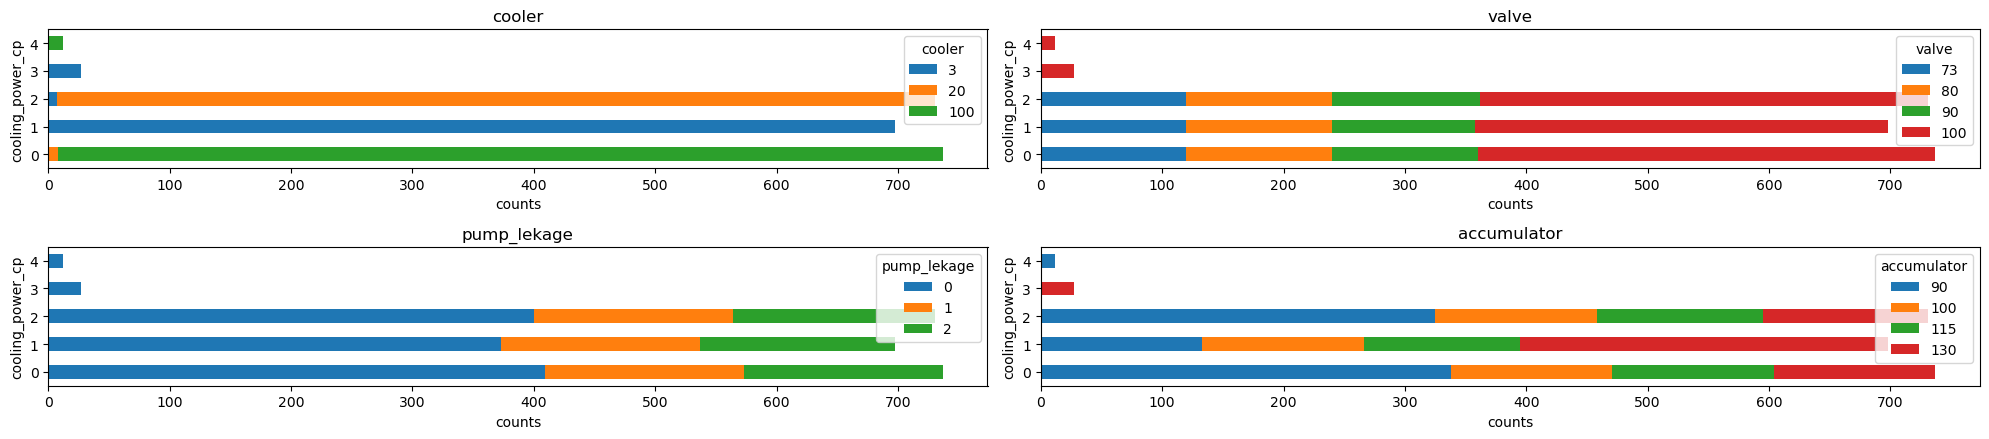

In [11]:
sensor_type = 'cooling_power'
cluster_models = {}
for sensor_name, data_array_ in ts_data_array[sensor_type].items():
    # fit kmeans cluster for ts array which best k( it identifies best K internally.)
    cluster_models[sensor_name] = ts_cluster_with_best_k(data_array_, sensor_name)
    plot_cluster_shapes(data_array_, cluster_models[sensor_name])
    # updating target data table with identified clusters
    target[f'{sensor_name.lower()}'] = cluster_models[sensor_name].labels_
    plot_target_counts_in_cluster(target, f'{sensor_name.lower()}')

### Efficiency Factor

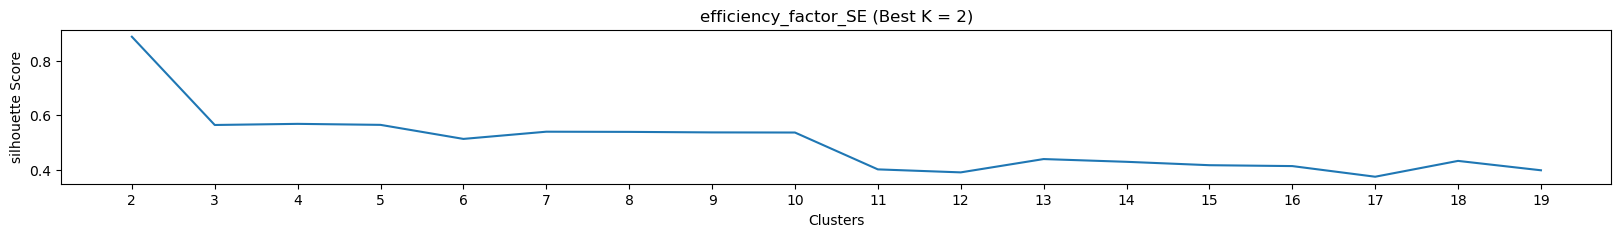

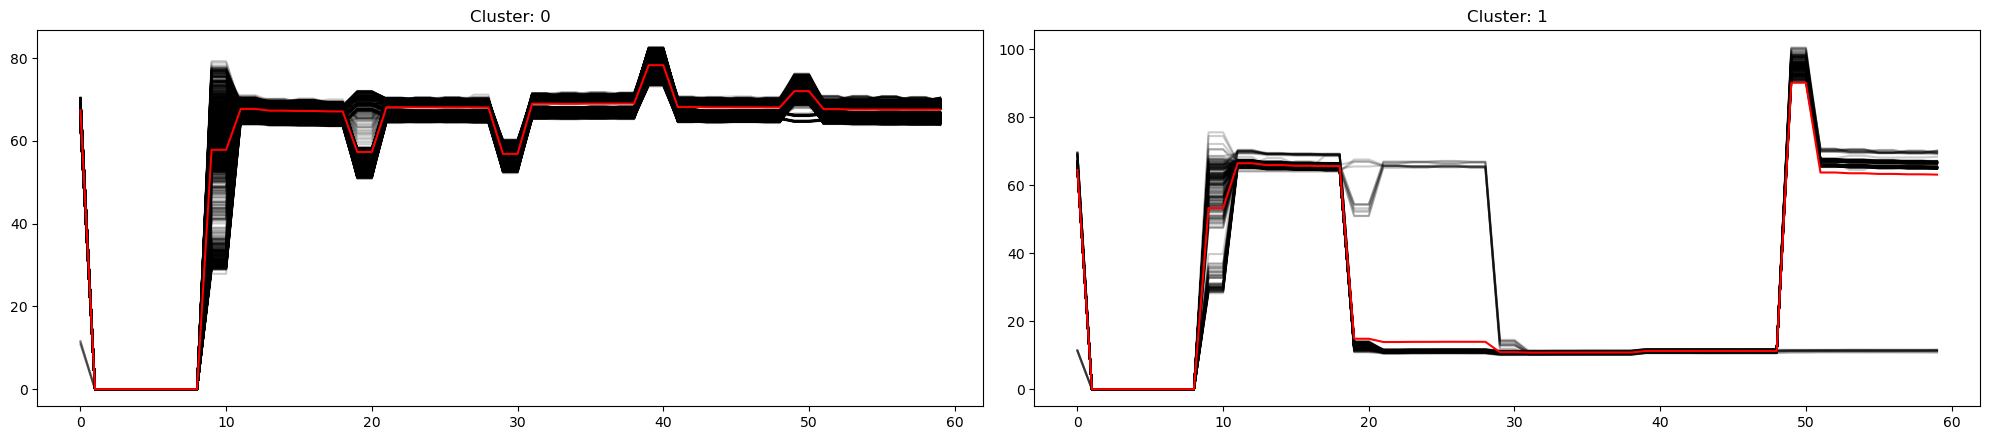

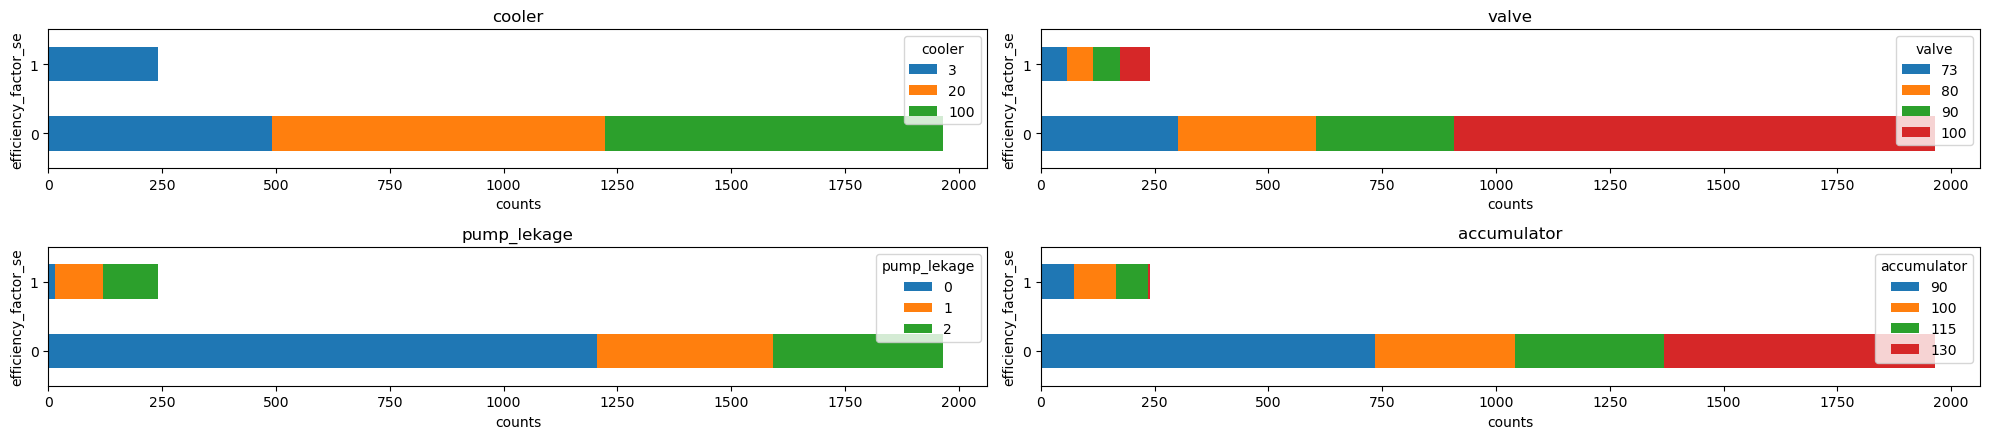

In [12]:
sensor_type = 'efficiency_factor'
cluster_models = {}
for sensor_name, data_array_ in ts_data_array[sensor_type].items():
    # fit kmeans cluster for ts array which best k( it identifies best K internally.)
    cluster_models[sensor_name] = ts_cluster_with_best_k(data_array_, sensor_name)
    plot_cluster_shapes(data_array_, cluster_models[sensor_name])
    # updating target data table with identified clusters
    target[f'{sensor_name.lower()}'] = cluster_models[sensor_name].labels_
    plot_target_counts_in_cluster(target, f'{sensor_name.lower()}')

In [14]:
target.to_parquet(f"{DATA_PATH}outputs/eda_profile.parquet")